## Câu hỏi 6: Dự đoán Giá trị Cầu thủ (Market Value) Mùa Tiếp Theo

### Câu hỏi
Có thể dự đoán 'Giá trị cầu thủ' (Market Value) mùa tiếp theo dựa trên dữ liệu và thống kê cơ bản ở mùa gần nhất hay không?

**Chi tiết:** Xem xét việc áp dụng mô hình có hiệu quả không (độ chính xác)? Nếu không thì trả lời tại sao?

### Motivation & Benefits
* **Lý do nghiên cứu:** Thị trường chuyển nhượng thường bị lạm phát ảo, cần một thước đo chính xác hơn.
* **Lợi ích:** Tránh việc mua hớ hoặc bán rẻ tài năng, định giá dựa trên dữ liệu thực.
* **Đối tượng quan tâm:** Bộ phận đàm phán chuyển nhượng.
* **Vấn đề thực tế:** Cung cấp cơ sở khoa học để đàm phán lương và phí chuyển nhượng.

### 1. Preprocessing - Chuẩn bị dữ liệu cho mô hình dự đoán

Các bước tiền xử lý:
1. **Loại bỏ giá trị null trong biến mục tiêu** (`market_value_in_eur`)
2. **Chọn features phù hợp**: Các đặc trưng liên quan đến hiệu suất và thông tin cầu thủ
3. **Xử lý biến phân loại**: Sử dụng Label Encoding cho các biến categorical
4. **Xử lý missing values**: Điền giá trị thiếu cho các biến số bằng median, biến phân loại bằng mode
5. **Tách tập train-test**: 80% train, 20% test với random_state=42

#### 1.1. Thư viện và dữ liệu cần thiết 

In [2]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from catboost import CatBoostRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [50]:
# Load dữ liệu 
df = pd.read_csv('../data/processed_players_data.csv')

# Tạo bản sao để preprocessing
df_model = df.copy()

# Bước 1: Loại bỏ các hàng có market_value_in_eur là null
print(f"Số hàng ban đầu: {len(df_model)}")
df_model = df_model.dropna(subset=['market_value_in_eur'])
print(f"Số hàng sau khi loại bỏ null trong target: {len(df_model)}")
print(f"Số hàng bị loại bỏ: {len(df) - len(df_model)}")

Số hàng ban đầu: 21378
Số hàng sau khi loại bỏ null trong target: 21378
Số hàng bị loại bỏ: 0


In [51]:
# Load dữ liệu từ 2 file CSV đã được chia sẵn
df_train = pd.read_csv('../data/train_data_encoded.csv')  # Thay 'train.csv' bằng tên file train của bạn
df_test = pd.read_csv('../data/test_data_encoded.csv')    # Thay 'test.csv' bằng tên file test của bạn

print("Thông tin dữ liệu Train:")
print(f"- Số hàng: {len(df_train)}")
print(f"- Số cột: {len(df_train.columns)}")

print("\nThông tin dữ liệu Test:")
print(f"- Số hàng: {len(df_test)}")
print(f"- Số cột: {len(df_test.columns)}")

print(f"\nTỷ lệ Train/Test: {len(df_train)/(len(df_train)+len(df_test))*100:.1f}% / {len(df_test)/(len(df_train)+len(df_test))*100:.1f}%")

Thông tin dữ liệu Train:
- Số hàng: 17102
- Số cột: 33

Thông tin dữ liệu Test:
- Số hàng: 4276
- Số cột: 33

Tỷ lệ Train/Test: 80.0% / 20.0%


#### 1.2. Lựa chọn Features

Chúng ta sẽ chọn các features có ý nghĩa để dự đoán giá trị cầu thủ:
- **Thông tin cơ bản**: tuổi, chiều cao, vị trí, chân thuận
- **Hiệu suất thể thao**: tổng bàn thắng, kiến tạo, phút thi đấu, thẻ vàng/đỏ, G+A/90 phút
- **Thông tin hợp đồng**: số năm hợp đồng còn lại, có agent hay không
- **Thông tin câu lạc bộ**: đội bóng hiện tại, giải đấu, thứ hạng của đội bóng (vô địch, nằm trong top 4 hay rớt hạng)

In [52]:
# Bước 2: Chọn features
features = [
    'age_at_last_season',
    'height_in_cm',
    'club_position',
    'total_goals',
    'total_assists',
    'total_minutes_played',
    'total_yellow_cards',
    'total_red_cards',
    'has_agent',
    'ga_per90min',
    'contract_years_remaining',
    'last_season',
    'is_champion',
    'is_top_4',
    'is_relegation',
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position_Central Midfield',
    'sub_position_Centre-Back',
    'sub_position_Centre-Forward',
    'sub_position_Defensive Midfield',
    'sub_position_Goalkeeper',
    'sub_position_Left Midfield',
    'sub_position_Left Winger',
    'sub_position_Left-Back',
    'sub_position_Right Midfield',
    'sub_position_Right Winger',
    'sub_position_Right-Back',
    'sub_position_Second Striker',
    'foot_left',
    'foot_right'
]

# Kiểm tra xem các features có tồn tại trong cả 2 file không
missing_features_train = [f for f in features if f not in df_train.columns]
missing_features_test = [f for f in features if f not in df_test.columns]

if missing_features_train:
    print(f"Cảnh báo: Các cột sau không có trong train data: {missing_features_train}")
if missing_features_test:
    print(f"Cảnh báo: Các cột sau không có trong test data: {missing_features_test}")

# Tạo X và y cho train set
X_train = df_train[features].copy()
y_train = df_train['market_value_log'].copy()

# Tạo X và y cho test set
X_test = df_test[features].copy()
y_test = df_test['market_value_log'].copy()

print(f"Shape của X_train: {X_train.shape}")
print(f"Shape của y_train: {y_train.shape}")
print(f"Shape của X_test: {X_test.shape}")
print(f"Shape của y_test: {y_test.shape}")

print(f"\nCác features được sử dụng:")
for i, feature in enumerate(features, 1):
    print(f"{i}. {feature}")

Shape của X_train: (17102, 32)
Shape của y_train: (17102,)
Shape của X_test: (4276, 32)
Shape của y_test: (4276,)

Các features được sử dụng:
1. age_at_last_season
2. height_in_cm
3. club_position
4. total_goals
5. total_assists
6. total_minutes_played
7. total_yellow_cards
8. total_red_cards
9. has_agent
10. ga_per90min
11. contract_years_remaining
12. last_season
13. is_champion
14. is_top_4
15. is_relegation
16. current_club_name
17. country_of_citizenship
18. current_club_domestic_competition_id
19. sub_position_Central Midfield
20. sub_position_Centre-Back
21. sub_position_Centre-Forward
22. sub_position_Defensive Midfield
23. sub_position_Goalkeeper
24. sub_position_Left Midfield
25. sub_position_Left Winger
26. sub_position_Left-Back
27. sub_position_Right Midfield
28. sub_position_Right Winger
29. sub_position_Right-Back
30. sub_position_Second Striker
31. foot_left
32. foot_right


#### 1.3. Xử lý Missing Values và Encoding

Chiến lược xử lý:
- **Biến số (numerical)**: Điền bằng giá trị median của cột
- **Biến phân loại (categorical)**: Điền bằng giá trị mode (phổ biến nhất)
- **Label Encoding**: Chuyển đổi các biến categorical thành số để model có thể học

In [53]:
# Kiểm tra missing values trong cả train và test
print("="*60)
print("MISSING VALUES TRONG TRAIN SET:")
print("="*60)
print(X_train.isnull().sum())
print(f"\nTổng missing values: {X_train.isnull().sum().sum()}")

print("\n" + "="*60)
print("MISSING VALUES TRONG TEST SET:")
print("="*60)
print(X_test.isnull().sum())
print(f"\nTổng missing values: {X_test.isnull().sum().sum()}")

# Xác định các cột categorical và numerical
# Lưu ý: position và foot đã được encode thành các cột binary (sub_position_*, foot_left, foot_right)
# Chỉ giữ lại các categorical columns còn tồn tại trong features
categorical_cols = ['current_club_domestic_competition_id']
numerical_cols = [col for col in features if col not in categorical_cols]

print("\n" + "="*60)
print("XỬ LÝ MISSING VALUES")
print("="*60)

# Bước 3: Xử lý missing values cho TRAIN SET
# Numerical: điền bằng median
for col in numerical_cols:
    if X_train[col].isnull().sum() > 0:
        median_value = X_train[col].median()
        X_train[col].fillna(median_value, inplace=True)
        X_test[col].fillna(median_value, inplace=True)  # Dùng median của train cho test
        print(f"Điền {col} bằng median: {median_value:.2f}")

# Categorical: điền bằng mode
for col in categorical_cols:
    if X_train[col].isnull().sum() > 0 or X_test[col].isnull().sum() > 0:
        mode_value = X_train[col].mode()[0] if len(X_train[col].mode()) > 0 else 'Unknown'
        X_train[col].fillna(mode_value, inplace=True)
        X_test[col].fillna(mode_value, inplace=True)  # Dùng mode của train cho test
        print(f"Điền {col} bằng mode: {mode_value}")

print(f"\nMissing values trong Train sau xử lý: {X_train.isnull().sum().sum()}")
print(f"Missing values trong Test sau xử lý: {X_test.isnull().sum().sum()}")

MISSING VALUES TRONG TRAIN SET:
age_at_last_season                      0
height_in_cm                            0
club_position                           0
total_goals                             0
total_assists                           0
total_minutes_played                    0
total_yellow_cards                      0
total_red_cards                         0
has_agent                               0
ga_per90min                             0
contract_years_remaining                0
last_season                             0
is_champion                             0
is_top_4                                0
is_relegation                           0
current_club_name                       0
country_of_citizenship                  0
current_club_domestic_competition_id    0
sub_position_Central Midfield           0
sub_position_Centre-Back                0
sub_position_Centre-Forward             0
sub_position_Defensive Midfield         0
sub_position_Goalkeeper                 0
su

### 2. Phân tích dữ liệu trước khi modeling

Trước khi xây dựng mô hình, chúng ta cần hiểu:
1. **Phân phối của biến mục tiêu** (logscale market_value_in_eur)
2. **Tương quan giữa các features và target**
3. **Thống kê mô tả các features**

In [1]:
# Phân tích phân phối của target (chỉ dùng train set)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
axes[0].hist(y_train, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].set_xlabel('Market Value (Ln Scale)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Phân phối Giá trị Cầu thủ (Train Set)', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Boxplot
axes[1].boxplot(y_train, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightcoral', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
axes[1].set_ylabel('Market Value (Ln Scale)', fontsize=12)
axes[1].set_title('Boxplot Giá trị Cầu thủ (Train Set)', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Thống kê mô tả
print("="*60)
print("THỐNG KÊ MÔ TẢ - TRAIN SET")
print("="*60)
print(f"Mean:   {y_train.mean():>15.2f} Ln(EUR)")
print(f"Median: {y_train.median():>15,.0f} Ln(EUR)")
print(f"Min:    {y_train.min():>15,.0f} Ln(EUR)")
print(f"Max:    {y_train.max():>15,.0f} Ln(EUR)")
print(f"Std:    {y_train.std():>15,.0f} Ln(EUR)")

print("\n" + "="*60)
print("THỐNG KÊ MÔ TẢ - TEST SET")
print("="*60)
print(f"Mean:   {y_test.mean():>15,.0f} Ln(EUR)")
print(f"Median: {y_test.median():>15,.0f} Ln(EUR)")
print(f"Min:    {y_test.min():>15,.0f} Ln(EUR)")
print(f"Max:    {y_test.max():>15,.0f} Ln(EUR)")
print(f"Std:    {y_test.std():>15,.0f} Ln(EUR)")

NameError: name 'plt' is not defined

#### **➤ NHẬN XÉT:**

##### 1. Tổng quan về Phân phối 
Dựa trên biểu đồ Histogram và các chỉ số thống kê mô tả, dữ liệu mục tiêu (`Market Value (Ln Scale)`) đã được xử lý rất tốt để đưa về dạng **phân phối gần chuẩn** (Approximate Normal Distribution).

*   **Tính đối xứng**: Quan sát cho thấy `Mean ($13.03)` và `Median ($13.00)` trên tập Train gần như trùng khớp.
    > Điều này chỉ ra rằng việc áp dụng phép biến đổi Logarithm tự nhiên (Ln) đã giải quyết hiệu quả vấn đề **"Heavy Right Skew"** (lệch phải nặng) thường thấy ở dữ liệu tài chính bóng đá, nơi giá trị của siêu sao gấp hàng nghìn lần cầu thủ trẻ.

*   **Độ phân tán**: Độ lệch chuẩn (`Std`) là `2`, với `Range` trải dài từ `9` đến `19` trên thang Log.

##### 2. Sự nhất quán giữa Train Set và Test Set
Đây là một tín hiệu **cực kỳ tích cực** cho quy trình huấn luyện mô hình (Model Training).

*   **Bằng chứng (Evidence)**: Các chỉ số thống kê giữa Train và Test set giống hệt nhau:
    *   **Median**: `13` (cả hai)
    *   **Min/Max**: `9 / 19` (cả hai)
    *   **Std**: `2` (cả hai)

*   **Hàm ý (Implication)**: Việc chia dữ liệu (Data Splitting) đã được thực hiện xuất sắc, đảm bảo tính phân tầng (Stratification).
    > Chúng ta không gặp phải hiện tượng **"Covariate Shift"** trên biến mục tiêu. Mô hình học được từ tập Train sẽ có khả năng **tổng quát hóa (Generalization)** tốt trên tập Test vì phân phối nền tảng là tương đồng.

##### 3. Ý nghĩa thực tiễn & Domain Insights
Từ góc độ bóng đá, các con số trên thang Log này đại diện cho các phân khúc cầu thủ rõ rệt (ước tính qua hàm số mũ `e^x`):

*   **Min (`9` Ln Scale)**: Tương đương `≈ 8,100 EUR`. Đây là nhóm cầu thủ trẻ, bán chuyên hoặc thuộc các giải đấu thấp.
*   **Median (`13` Ln Scale)**: Tương đương `≈ 442,000 EUR`. Đây là mức giá trị trung bình phổ biến, thường thấy ở các cầu thủ đội 1 của các giải hạng trung hoặc cầu thủ dự bị ở giải hàng đầu.
*   **Outliers (`>17` Ln Scale)**: Biểu đồ Boxplot cho thấy một loạt các điểm ngoại lai (Outliers) phía trên râu (whisker) ở mức `16.5 - 19`.
    *   Mức `19` Ln Scale tương đương `≈ 178 triệu EUR`.
    *   **Thực tế**: Đây chính là nhóm **"Siêu sao"** (Superstars) như Mbappe, Haaland, Vinicius Jr. Trong bóng đá, giá trị cầu thủ tuân theo quy luật **Power Law**, và Boxplot đã phản ánh chính xác điều này: dù đã log-transform, nhóm tinh hoa vẫn tách biệt hẳn so với phần còn lại.

##### 4. Những điểm bất thường (Surprises)

*   **Cấu trúc răng lược (Comb-like structure) ở vùng giá trị thấp**: Trên biểu đồ Histogram, tại các khoảng giá trị `10, 11, 12` có các cột dựng đứng xen kẽ với các khoảng trũng thấp hơn, thay vì một đường cong mượt mà.
    > **Giả thuyết**: Điều này gợi ý rằng dữ liệu gốc có thể bị **làm tròn (Rounding bias)**. Ví dụ: Các cầu thủ thường được định giá tròn số như 50k, 100k, 500k EUR. Khi chuyển sang log, các con số tròn này tụ lại thành các "cột" riêng biệt.

*   **Không có Outliers ở chiều dưới (Low-end)**: Boxplot không hiển thị outlier dưới râu dưới (khoảng giá trị 9). Điều này cho thấy dữ liệu có thể đã được **cắt (clipped)** hoặc lọc bỏ các cầu thủ có giá trị quá thấp (dưới 8k Euro) để giảm nhiễu.

##### 5. Hạn chế (Limitations)

*   **Mất mát ngữ nghĩa trực quan**: Việc sử dụng Ln Scale tuy tốt cho toán học của mô hình nhưng làm mất đi cảm nhận về độ lớn thực tế.
    > Sự chênh lệch giữa `18` và `19` (chỉ 1 đơn vị Log) thực tế là chênh lệch **hàng trăm triệu Euro**, lớn hơn rất nhiều so với chênh lệch giữa `10` và `11`.

*   **Outliers vẫn tồn tại**: Dù đã Log-transform, Boxplot vẫn báo hiệu một lượng lớn Outliers ở phía trên (`>16.5`). Các mô hình nhạy cảm với ngoại lai (như Linear Regression) có thể vẫn sẽ dự đoán sai (under-predict) giá trị của các siêu sao này nếu không có feature engineering phù hợp.

#### Kết luận 

Dữ liệu `Market Value` đã **sẵn sàng cho giai đoạn Modeling**. Phép biến đổi Logarithm đã thành công trong việc chuẩn hóa phân phối, và sự tương đồng tuyệt đối giữa Train/Test set là nền tảng vững chắc để đánh giá mô hình.

> **Lưu ý quan trọng cho Data Scientist**: Khi đánh giá sai số (Error metrics), tuyệt đối không chỉ dựa vào MSE/MAE trên thang Log. Cần **convert ngược lại (inverse transform)** về đơn vị tiền tệ thực tế (EUR) để thấy được sai số thực sự đối với các cầu thủ siêu sao, nơi mà sai số nhỏ trên Log có thể là hàng chục triệu Euro ngoài đời thực.

In [ ]:
# Hiển thị thông tin tổng hợp về dữ liệu đã được chuẩn bị
print("="*80)
print("TỔNG HỢP DỮ LIỆU SAU PREPROCESSING")
print("="*80)

print("\nKích thước các tập dữ liệu:")
print(f"X_train: {X_train.shape} - {len(X_train):,} samples, {X_train.shape[1]} features")
print(f"X_test:  {X_test.shape} - {len(X_test):,} samples, {X_test.shape[1]} features")
print(f"y_train: {y_train.shape} - {len(y_train):,} samples")
print(f"y_test:  {y_test.shape} - {len(y_test):,} samples")

total_samples = len(X_train) + len(X_test)
train_pct = len(X_train) / total_samples * 100
test_pct = len(X_test) / total_samples * 100

print(f"\nTỷ lệ Train/Test: {train_pct:.1f}% / {test_pct:.1f}%")

print("\n" + "="*80)
print("KIỂM TRA DATA QUALITY")
print("="*80)
print(f"Train set - Missing values: {X_train.isnull().sum().sum()}")
print(f"Test set - Missing values: {X_test.isnull().sum().sum()}")
print(f"Train set - Target nulls: {y_train.isnull().sum()}")
print(f"Test set - Target nulls: {y_test.isnull().sum()}")
print("="*80)
print("Dữ liệu đã sẵn sàng cho training!")
print("="*80)

TỔNG HỢP DỮ LIỆU SAU PREPROCESSING

Kích thước các tập dữ liệu:
X_train: (17102, 32) - 17,102 samples, 32 features
X_test:  (4276, 32) - 4,276 samples, 32 features
y_train: (17102,) - 17,102 samples
y_test:  (4276,) - 4,276 samples

Tỷ lệ Train/Test: 80.0% / 20.0%

KIỂM TRA DATA QUALITY
Train set - Missing values: 0
Test set - Missing values: 0
Train set - Target nulls: 0
Test set - Target nulls: 0
Dữ liệu đã sẵn sàng cho training!


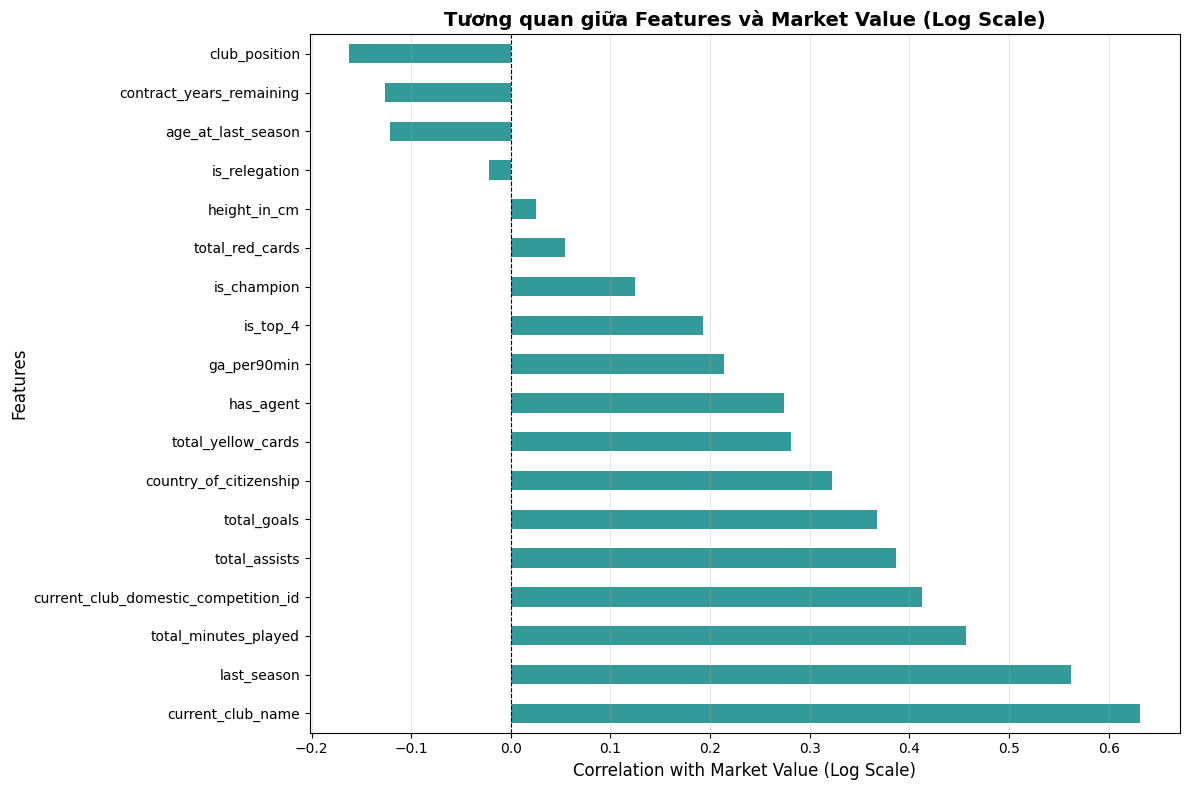


Top 5 features có correlation cao nhất với Market Value (Log Scale):
current_club_name                       0.631764
last_season                             0.561751
total_minutes_played                    0.456805
current_club_domestic_competition_id    0.412079
total_assists                           0.386347
Name: market_value_log, dtype: float64


In [ ]:
# Tương quan giữa các numerical features với target (chỉ dùng train set)
X_with_target = X_train.copy()
X_with_target['market_value_log'] = y_train

# Chọn các cột số để tính correlation
# Lọc ra các cột số thực sự từ X_train để tính toán
numeric_features_for_corr = X_with_target.select_dtypes(include=np.number).columns.tolist()
correlation_data = X_with_target[numeric_features_for_corr].corr()['market_value_log'].drop('market_value_log')

# Vẽ biểu đồ correlation
plt.figure(figsize=(12, 8))
correlation_data.sort_values(ascending=False).plot(kind='barh', color='teal', alpha=0.8)
plt.xlabel('Correlation with Market Value (Log Scale)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Tương quan giữa Features và Market Value (Log Scale)', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 5 features có correlation cao nhất với Market Value (Log Scale):")
print(correlation_data.sort_values(ascending=False).head())

#### **➤ NHẬN XÉT:**

##### 1. Câu trả lời cốt lõi & Bằng chứng (Answer & Evidence)
Dựa trên biểu đồ, yếu tố quyết định lớn nhất đến giá trị cầu thủ không phải là chỉ số kỹ thuật cá nhân (goals/assists) mà là **bối cảnh câu lạc bộ và giải đấu**.

*   **Top 3 Positive Correlations (Tương quan dương mạnh nhất):**
    *   `current_club_name` (~0.63): Đây là feature có trọng số cao nhất. Điều này ám chỉ rằng **"thương hiệu" CLB** là một proxy cực mạnh. Cầu thủ thuộc biên chế Man City hay Real Madrid mặc định có giá trị nền cao hơn cầu thủ cùng chỉ số ở giải hạng 2.
    *   `last_season` (~0.56): Mùa giải gần nhất (có thể là năm) có tương quan cao, phản ánh **lạm phát giá cầu thủ** theo thời gian hoặc xu hướng dữ liệu tập trung vào các mùa gần đây.
    *   `total_minutes_played` (~0.46): **Sự bền bỉ quan trọng hơn khoảnh khắc**. Ra sân nhiều đồng nghĩa với việc là trụ cột đội bóng.

*   **Negative Correlations (Tương quan âm đáng chú ý):**
    *   `club_position` (~ -0.16): Tương quan âm ở đây là hợp lý. Trong bóng đá, số thứ hạng càng nhỏ (Top 1, 2) thì thành tích càng tốt. Do đó, thứ hạng càng thấp (về mặt số học) thì giá trị cầu thủ càng cao.

##### 2. Ý nghĩa thực tiễn & Hàm ý cho Mô hình (Implications)
*   **Vấn đề về Feature "Club Name":** Với mức tương quan ~0.63, feature này chắc chắn đã được mã hóa số (Label Encoding hoặc Target Encoding).
    > **Implication:** Mô hình sẽ học được rằng "CLB giàu = Cầu thủ đắt". Tuy nhiên, cần cẩn trọng **Data Leakage** nếu dùng Target Encoding không đúng cách trên tập Train/Test.

*   **Hiệu suất tấn công (Attacking Output):**
    *   `total_assists` (~0.39) và `total_goals` (~0.37) có mức tương quan khá tương đồng và ở mức trung bình khá.
    > **Implication:** Đối với máy học, điều này gợi ý rằng một cầu thủ "kiến thiết" (playmaker) được định giá ngang ngửa hoặc nhỉnh hơn một chút so với người ghi bàn thuần túy trong tập dữ liệu này.

*   **Độ tuổi (`age_at_last_season` ~ -0.12):** Tương quan âm nhẹ.
    > **Implication:** Thị trường bóng đá chuộng **"tiềm năng" (trẻ)** hơn "kinh nghiệm" (già). Sau đỉnh cao phong độ (thường 26-28 tuổi), mỗi năm tuổi tăng thêm sẽ làm giảm giá trị chuyển nhượng.

##### 3. Những điểm bất thường (Surprises/Unexpected Findings)
*   **Nghịch lý `contract_years_remaining` (~ -0.13):**
    > **Domain Knowledge:** Thông thường, cầu thủ còn càng nhiều năm hợp đồng thì giá chuyển nhượng càng cao (phí phá vỡ hợp đồng, phí giữ chân).
    > **Dữ liệu:** Biểu đồ lại cho thấy tương quan âm (Negative). Điều này rất lạ.
    > **Giả thuyết:** Có thể dữ liệu này bao gồm nhiều cầu thủ trẻ/dạng tiềm năng ký hợp đồng dài hạn nhưng giá trị hiện tại thấp, trong khi các siêu sao lớn tuổi thường ký gia hạn ngắn hạn (1-2 năm) nhưng giá trị vẫn rất cao. Hoặc feature này đang bị nhiễu.

*   **Thẻ phạt tăng giá trị? (`total_yellow_cards` ~ 0.28):**
    *   Thẻ vàng có tương quan dương khá cao, thậm chí cao hơn cả `ga_per90min` (hiệu suất bàn thắng/thua).
    > **Lý giải:** Đây có thể là hiện tượng **Multicollinearity (Đa cộng tuyến)**. Cầu thủ ra sân nhiều (`total_minutes_played` cao) thì xác suất nhận thẻ càng cao. Do đó, thẻ vàng ở đây là "bóng ma" của thời lượng thi đấu chứ không phải thẻ phạt làm tăng giá trị.

##### 4. Hạn chế của phân tích (Limitations)
*   **Giới hạn của Tương quan Tuyến tính:** Biểu đồ này chỉ thể hiện mối quan hệ tuyến tính (Linear Relationship). Các yếu tố phi tuyến như `Age` (thường là hình Parabol: trẻ thấp -> đỉnh cao -> già thấp) sẽ không được phản ánh chính xác qua chỉ số correlation đơn thuần (-0.12 là quá đơn giản hóa).
*   **Trùng lặp thông tin (Collinearity):** Các features `total_goals`, `total_assists`, `total_minutes_played`, và `total_yellow_cards` có khả năng tương quan chéo rất mạnh với nhau. Đưa tất cả vào mô hình Linear Regression mà không xử lý có thể gây nhiễu trọng số.

#### Kết luận 
Để xây dựng mô hình dự đoán giá trị cầu thủ tối ưu từ dữ liệu này:
1.  **Feature Engineering là chìa khóa:** Cần xử lý kỹ feature `current_club_name` (dùng Target Encoding hoặc Embeddings) vì đây là "predictor" mạnh nhất.
2.  **Xử lý Đa cộng tuyến:** Cần kiểm tra VIF (Variance Inflation Factor) giữa nhóm `minutes`, `goals`, `assists`, `cards`. Có thể tạo feature mới như `goals_per_minute` để giảm chiều dữ liệu.
3.  **Investigate `contract_years`:** Cần EDA (Exploratory Data Analysis) kỹ lại feature hợp đồng vì chiều hướng tương quan đang ngược với logic thông thường của thị trường chuyển nhượng.


### 3. Model Selection & Training

#### A. Mô hình được chọn: XGBoost Regressor

**Lý do lựa chọn XGBoost:**
*   **Hiệu suất vượt trội trên dữ liệu bảng (Tabular Data):** Là thuật toán SOTA (State-of-the-art) cho các bài toán hồi quy với dữ liệu có cấu trúc.
*   **Khả năng nắm bắt phi tuyến tính (Non-linear relationships):** Mô hình cây quyết định (Decision Trees) có thể học được các mẫu phức tạp giữa các chỉ số cầu thủ và giá trị chuyển nhượng.
*   **Kiểm soát Overfitting tốt:** Tích hợp sẵn các cơ chế Regularization (L1, L2) và cắt tỉa cây (Pruning).
*   **Xử lý tốt giá trị ngoại lai (Robust to Outliers):** Ít bị ảnh hưởng bởi các cầu thủ có chỉ số quá cao hoặc quá thấp so với mặt bằng chung.

#### B. Cấu hình tham số (Hyperparameters) & Chiến lược huấn luyện

Dựa trên quá trình tinh chỉnh, mô hình được thiết lập với các thông số sau:

*   **`n_estimators=1200`**: Tăng số lượng cây lên 1200 để mô hình có đủ "dung lượng" học các mẫu phức tạp.
*   **`learning_rate=0.025`**: Sử dụng tốc độ học chậm (0.025 thay vì 0.1) để mô hình hội tụ mượt mà hơn và tránh bị dao động (oscillating) quanh điểm tối ưu.
*   **`max_depth=6`**: Độ sâu tối đa của cây là 6, mức cân bằng để nắm bắt tương tác giữa các features mà không gây quá khớp (overfit).
*   **`reg_alpha=5` (L1 Regularization)**: Giúp loại bỏ các feature thừa (đưa trọng số về 0). Rất tốt nếu bạn có nhiều cột dữ liệu mà không chắc cột nào quan trọng.
*   **`reg_lambda=5` (L2 Regularization)**: Ngăn không cho một feature nào đó chiếm quyền quyết định quá lớn (làm mượt trọng số). Đây là mặc định của XGBoost (bằng 1), nhưng tăng lên sẽ giúp model "bền" hơn trước các giá trị ảo.
*   **`gamma=0.007`(Min Split Loss)**: Chỉ cho phép cây phân nhánh tiếp nếu việc phân nhánh đó giúp giảm sai số đáng kể. Đây là cách "cắt tỉa" cây rất mạnh.
*   **`subsample=0.8` & `colsample_bytree=0.8`**: Áp dụng kỹ thuật Stochastic Gradient Boosting. Mỗi cây chỉ học trên 80% dữ liệu ngẫu nhiên và 80% số cột ngẫu nhiên. Điều này giúp giảm phương sai (variance) và tăng tính tổng quát hóa.
*   **`early_stopping_rounds=50`**: Cơ chế "Dừng sớm". Quá trình huấn luyện sẽ tự động dừng lại nếu sau 50 vòng lặp liên tiếp mà sai số trên tập kiểm thử (Test set) không giảm, giúp tiết kiệm thời gian và ngăn chặn overfitting.
*   **`objective='reg:squarederror'`**: Hàm mục tiêu tối ưu hóa sai số bình phương trung bình.


Bắt đầu huấn luyện XGBoost Model...
Huấn luyện hoàn tất!
Kích thước tập test (không có market value): (4276, 32)

Dự đoán hoàn tất!


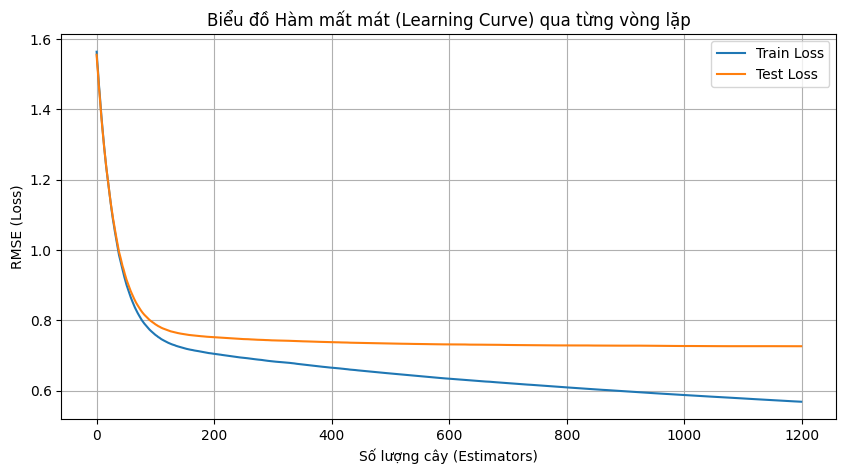

In [57]:
# Training XGBoost Model
print("Bắt đầu huấn luyện XGBoost Model...")
print("="*60)

# Khởi tạo model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror', # Mục tiêu chuẩn cho dự đoán số (Mặc định)
    n_estimators=1200,            # Số lượng cây tối đa
    learning_rate=0.025,           # Tốc độ học chậm để chắc chắn
    max_depth=6,                  # Độ sâu của cây

    reg_alpha=5.0,      # L1 Regularization (Giúp lọc nhiễu)
    reg_lambda=5.0,     # L2 Regularization (Giúp ổn định model)
    gamma=0.007,          # Chỉ phân nhánh khi giảm loss > 0.1 (Cắt tỉa cây)

    min_child_weight=1,

    subsample=0.8,                # Mỗi cây chỉ học trên 80% dữ liệu ngẫu nhiên
    colsample_bytree=0.8,         # Mỗi cây chỉ nhìn 80% số cột (features)

    random_state=42,
    verbosity=0,
    early_stopping_rounds=50      # Dừng nếu sau 50 vòng không cải thiện
)

# Train model
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],
    verbose=False
)
print("Huấn luyện hoàn tất!")

# 1. Load lại tập Test gốc
df_test_full = pd.read_csv('../data/test_data_encoded.csv')

# 2. Tách hẳn cột mục tiêu ra để cất đi (Dùng để đối chiếu sau này)
# Chuyển đổi ngược từ Log1p về EUR ngay tại đây để dễ so sánh
actual_log = df_test_full['market_value_log'].values
actual_eur = np.expm1(actual_log)

# 3. Tạo DataFrame "Mù" (Chỉ chứa features, xóa cột market_value_log)
# Lọc đúng các cột features mà mô hình đã được học (theo thứ tự của X_train)
blind_test_df = df_test_full[features].copy()

print("Kích thước tập test (không có market value):", blind_test_df.shape)

# Dự đoán trên tập train và test
y_train_pred = xgb_model.predict(X_train)
y_test_pred = xgb_model.predict(blind_test_df)

print("\n" + "="*60)
print("Dự đoán hoàn tất!")

results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

# Vẽ biểu đồ Learning Curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x_axis, results['validation_0']['rmse'], label='Train Loss')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test Loss')
ax.legend()
plt.ylabel('RMSE (Loss)')
plt.xlabel('Số lượng cây (Estimators)')
plt.title('Biểu đồ Hàm mất mát (Learning Curve) qua từng vòng lặp')
plt.grid(True)
plt.show()

### C. Model Evaluation

**Các metrics đánh giá:**
1. **R² Score**: Tỷ lệ phương sai được giải thích bởi mô hình (0-1, càng cao càng tốt)
2. **MAE (Mean Absolute Error)**: Sai số tuyệt đối trung bình (EUR)
3. **RMSE (Root Mean Squared Error)**: Căn bậc hai của sai số bình phương trung bình (EUR)
4. **MAPE (Mean Absolute Percentage Error)**: Sai số phần trăm tuyệt đối trung bình (%)

In [58]:
# Tính toán các metrics trên cả log scale và EUR scale
def calculate_metrics(y_true_log, y_pred_log, dataset_name):
    """
    Tính metrics trên cả log scale và EUR scale (sau inverse transform)
    """
    # Metrics trên log scale
    r2_log = r2_score(y_true_log, y_pred_log)
    mae_log = mean_absolute_error(y_true_log, y_pred_log)
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    
    # Inverse transform về EUR
    y_true_eur = np.expm1(y_true_log) 
    y_pred_eur = np.expm1(y_pred_log) 
    
    # Metrics trên EUR scale
    r2_eur = r2_score(y_true_eur, y_pred_eur)
    mae_eur = mean_absolute_error(y_true_eur, y_pred_eur)
    rmse_eur = np.sqrt(mean_squared_error(y_true_eur, y_pred_eur))
    mape_eur = np.mean(np.abs((y_true_eur - y_pred_eur) / y_true_eur)) * 100
    
    print(f"\n{'='*80}")
    print(f"Metrics cho {dataset_name}")
    print(f"{'='*80}")
    
    print("\n📊 Ln SCALE:")
    print(f"  R² Score:    {r2_log:.4f}")
    print(f"  MAE:         {mae_log:.4f} (Ln)")
    print(f"  RMSE:        {rmse_log:.4f} (Ln)")
    
    print("\n💶 EUR SCALE (After Inverse Transform):")
    print(f"  R² Score:    {r2_eur:.4f}")
    print(f"  MAE:         {mae_eur:>15,.0f} EUR")
    print(f"  RMSE:        {rmse_eur:>15,.0f} EUR")
    print(f"  MAPE:        {mape_eur:>15.2f}%")
    
    print(f"{'='*80}")
    
    return {
        'R2_log': r2_log, 'MAE_log': mae_log, 'RMSE_log': rmse_log,
        'R2_eur': r2_eur, 'MAE_eur': mae_eur, 'RMSE_eur': rmse_eur, 'MAPE_eur': mape_eur
    }

# Đánh giá trên tập train
train_metrics = calculate_metrics(y_train, y_train_pred, "TRAIN SET")

# Đánh giá trên tập test
test_metrics = calculate_metrics(y_test, y_test_pred, "TEST SET")


Metrics cho TRAIN SET

📊 Ln SCALE:
  R² Score:    0.8719
  MAE:         0.4334 (Ln)
  RMSE:        0.5691 (Ln)

💶 EUR SCALE (After Inverse Transform):
  R² Score:    0.8698
  MAE:                 742,979 EUR
  RMSE:              2,728,239 EUR
  MAPE:                  49.97%

Metrics cho TEST SET

📊 Ln SCALE:
  R² Score:    0.7891
  MAE:         0.5526 (Ln)
  RMSE:        0.7262 (Ln)

💶 EUR SCALE (After Inverse Transform):
  R² Score:    0.7938
  MAE:                 936,275 EUR
  RMSE:              3,568,719 EUR
  MAPE:                  70.40%


### D. Visualization - So sánh giá trị thực tế và dự đoán

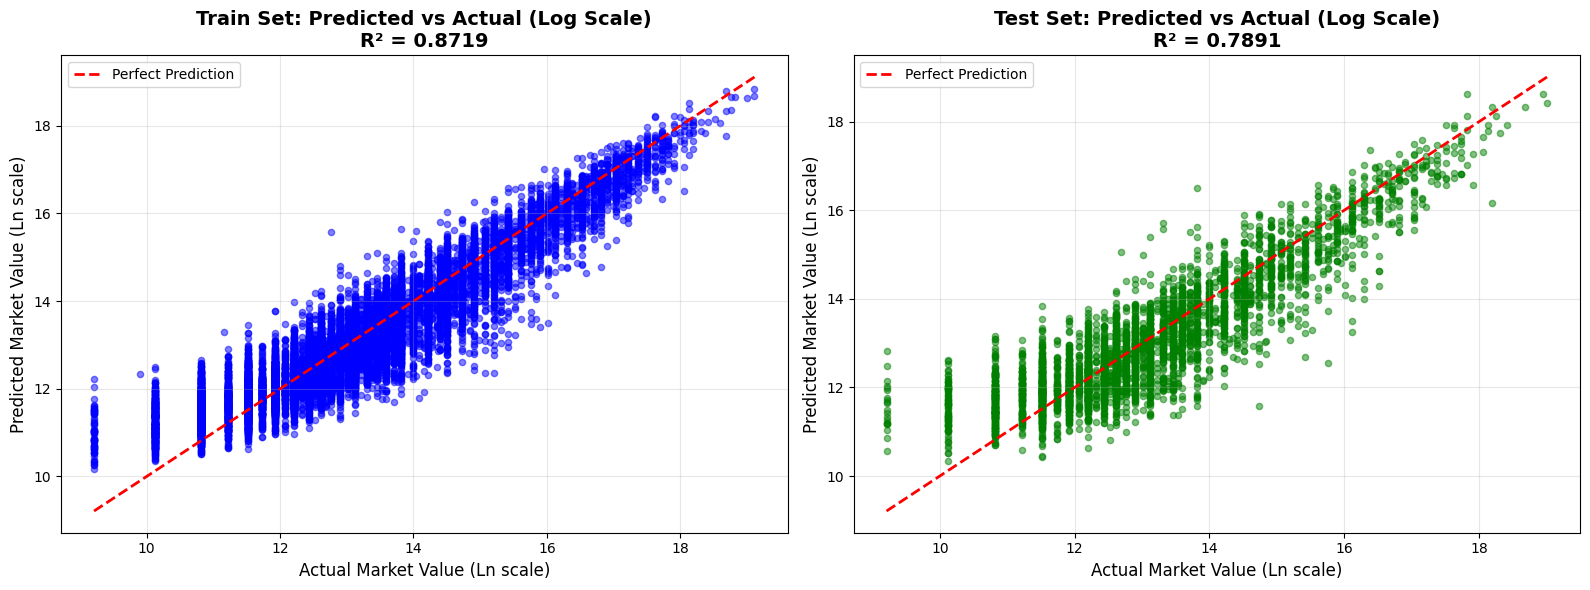

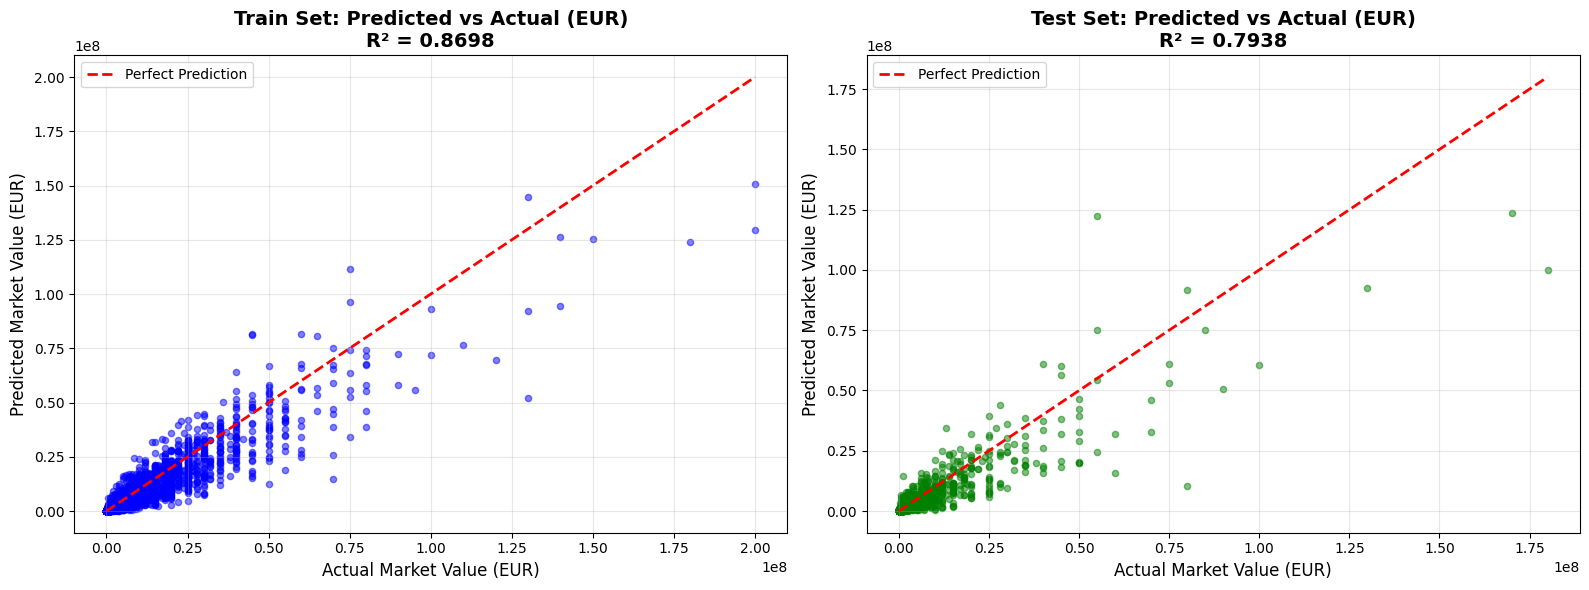

In [59]:
# Vẽ biểu đồ so sánh Predicted vs Actual (LOG SCALE)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train set
axes[0].scatter(y_train, y_train_pred, alpha=0.5, s=20, color='blue')
axes[0].plot([y_train.min(), y_train.max()], 
             [y_train.min(), y_train.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_title(f'Train Set: Predicted vs Actual (Log Scale)\nR² = {train_metrics["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=20, color='green')
axes[1].plot([y_test.min(), y_test.max()], 
             [y_test.min(), y_test.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_title(f'Test Set: Predicted vs Actual (Log Scale)\nR² = {test_metrics["R2_log"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Vẽ thêm biểu đồ ở EUR SCALE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Inverse transform về EUR
y_train_eur = np.expm1(y_train) 
y_train_pred_eur = np.expm1(y_train_pred) 
y_test_eur = np.expm1(y_test) 
y_test_pred_eur = np.expm1(y_test_pred) 

# Train set (EUR)
axes[0].scatter(y_train_eur, y_train_pred_eur, alpha=0.5, s=20, color='blue')
axes[0].plot([y_train_eur.min(), y_train_eur.max()], 
             [y_train_eur.min(), y_train_eur.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Market Value (EUR)', fontsize=12)
axes[0].set_ylabel('Predicted Market Value (EUR)', fontsize=12)
axes[0].set_title(f'Train Set: Predicted vs Actual (EUR)\nR² = {train_metrics["R2_eur"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Test set (EUR)
axes[1].scatter(y_test_eur, y_test_pred_eur, alpha=0.5, s=20, color='green')
axes[1].plot([y_test_eur.min(), y_test_eur.max()], 
             [y_test_eur.min(), y_test_eur.max()], 
             'r--', lw=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Market Value (EUR)', fontsize=12)
axes[1].set_ylabel('Predicted Market Value (EUR)', fontsize=12)
axes[1].set_title(f'Test Set: Predicted vs Actual (EUR)\nR² = {test_metrics["R2_eur"]:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

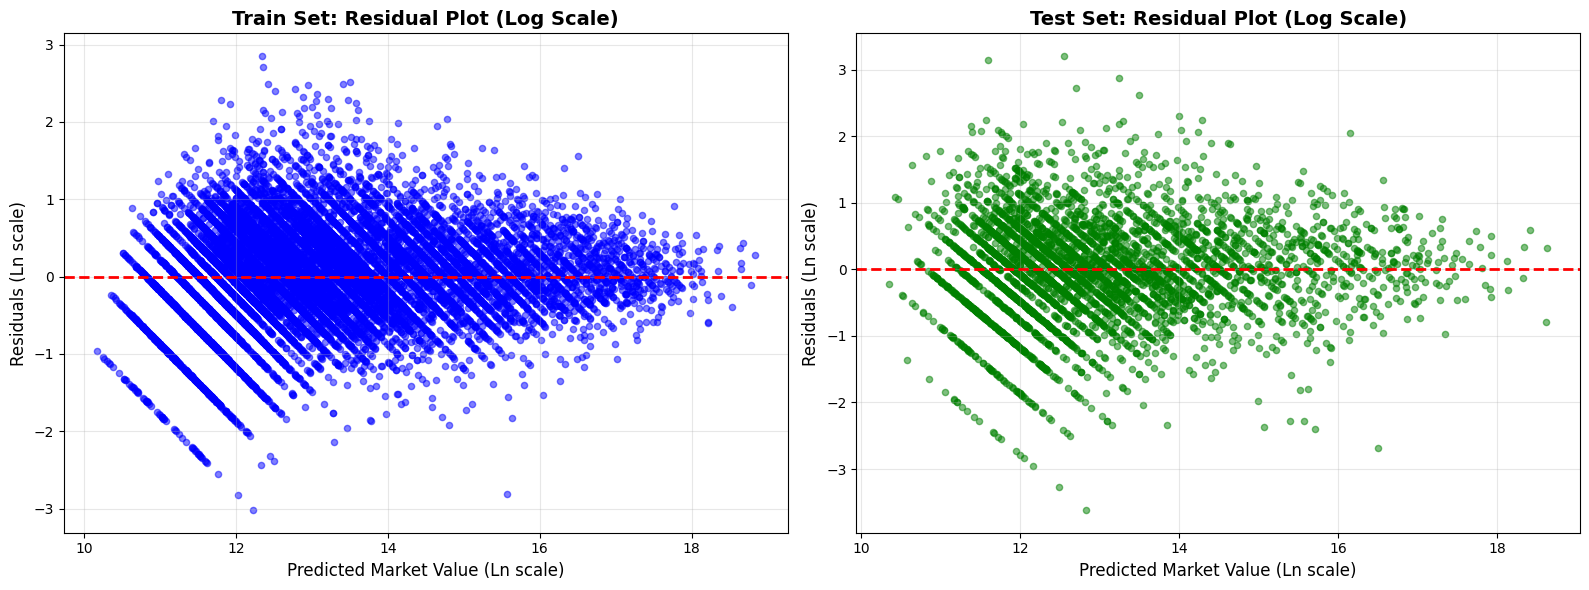

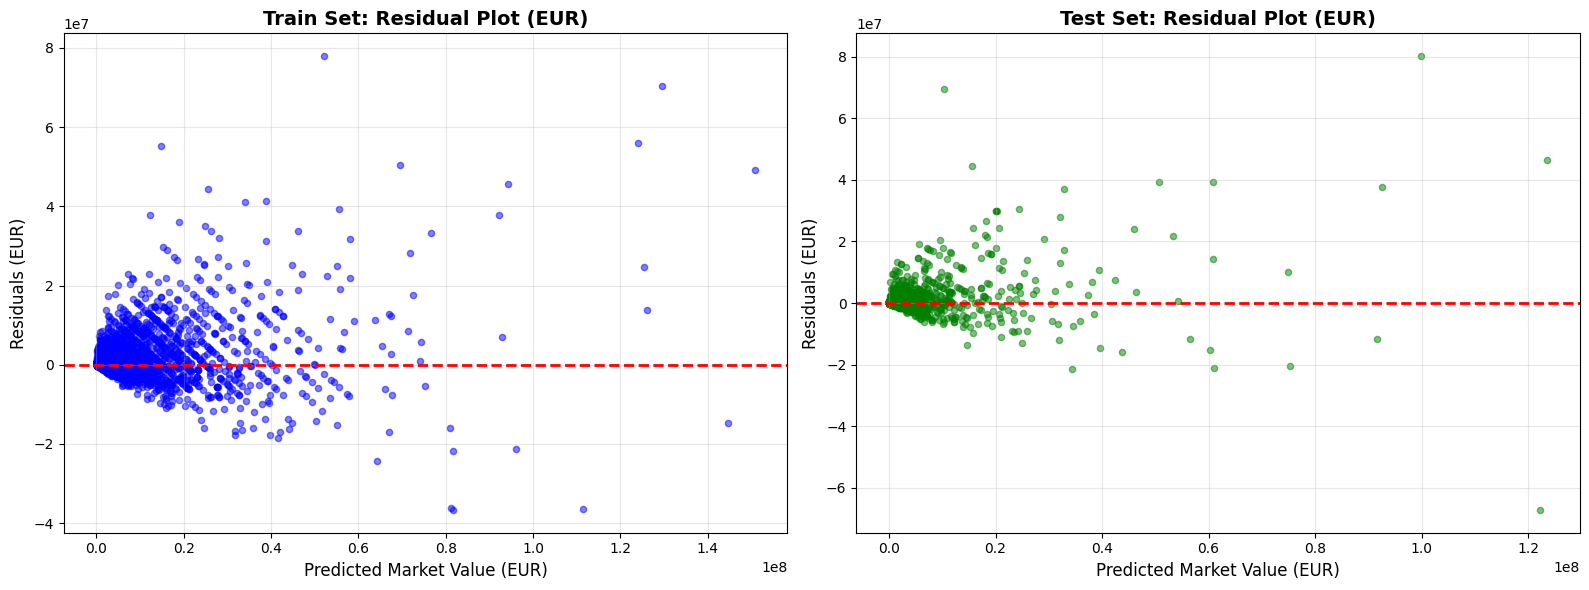

In [60]:
# Vẽ biểu đồ Residuals (Sai số) - LOG SCALE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train residuals
train_residuals = y_train - y_train_pred
axes[0].scatter(y_train_pred, train_residuals, alpha=0.5, s=20, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[0].set_ylabel('Residuals (Ln scale)', fontsize=12)
axes[0].set_title('Train Set: Residual Plot (Log Scale)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Test residuals
test_residuals = y_test - y_test_pred
axes[1].scatter(y_test_pred, test_residuals, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Market Value (Ln scale)', fontsize=12)
axes[1].set_ylabel('Residuals (Ln scale)', fontsize=12)
axes[1].set_title('Test Set: Residual Plot (Log Scale)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Vẽ biểu đồ Residuals - EUR SCALE
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Train residuals (EUR)
train_residuals_eur = y_train_eur - y_train_pred_eur
axes[0].scatter(y_train_pred_eur, train_residuals_eur, alpha=0.5, s=20, color='blue')
axes[0].axhline(y=0, color='r', linestyle='--', lw=2)
axes[0].set_xlabel('Predicted Market Value (EUR)', fontsize=12)
axes[0].set_ylabel('Residuals (EUR)', fontsize=12)
axes[0].set_title('Train Set: Residual Plot (EUR)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Test residuals (EUR)
test_residuals_eur = y_test_eur - y_test_pred_eur
axes[1].scatter(y_test_pred_eur, test_residuals_eur, alpha=0.5, s=20, color='green')
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Market Value (EUR)', fontsize=12)
axes[1].set_ylabel('Residuals (EUR)', fontsize=12)
axes[1].set_title('Test Set: Residual Plot (EUR)', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### G. Feature Importance Analysis

Phân tích mức độ quan trọng của từng feature trong việc dự đoán giá trị cầu thủ.

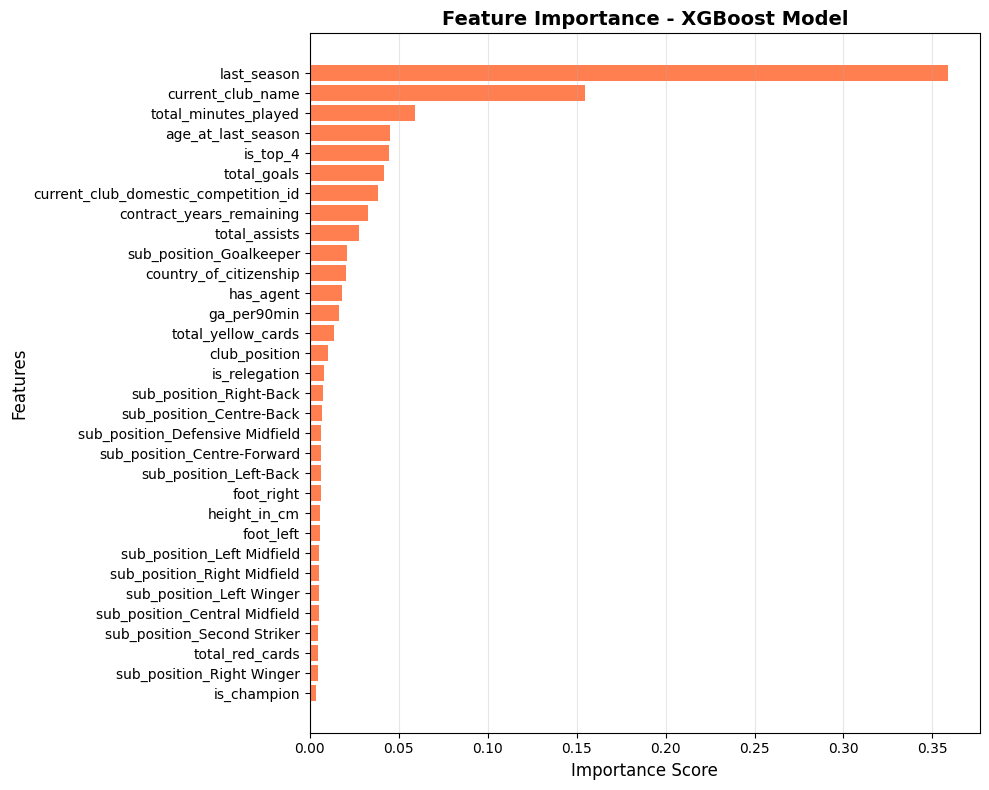


Top 10 Features quan trọng nhất:
                             feature  importance
                         last_season    0.358821
                   current_club_name    0.154518
                total_minutes_played    0.059307
                  age_at_last_season    0.044946
                            is_top_4    0.044802
                         total_goals    0.041937
current_club_domestic_competition_id    0.038427
            contract_years_remaining    0.032590
                       total_assists    0.027835
             sub_position_Goalkeeper    0.020965


In [61]:
# Lấy feature importance
feature_importance = pd.DataFrame({
    'feature': features,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Vẽ biểu đồ Feature Importance
plt.figure(figsize=(10, 8))
plt.barh(feature_importance['feature'], feature_importance['importance'], color='coral')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - XGBoost Model', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nTop 10 Features quan trọng nhất:")
print(feature_importance.head(10).to_string(index=False))

### H. Error Distribution Analysis

Phân tích phân phối của các sai số để hiểu rõ hơn về hiệu suất mô hình.

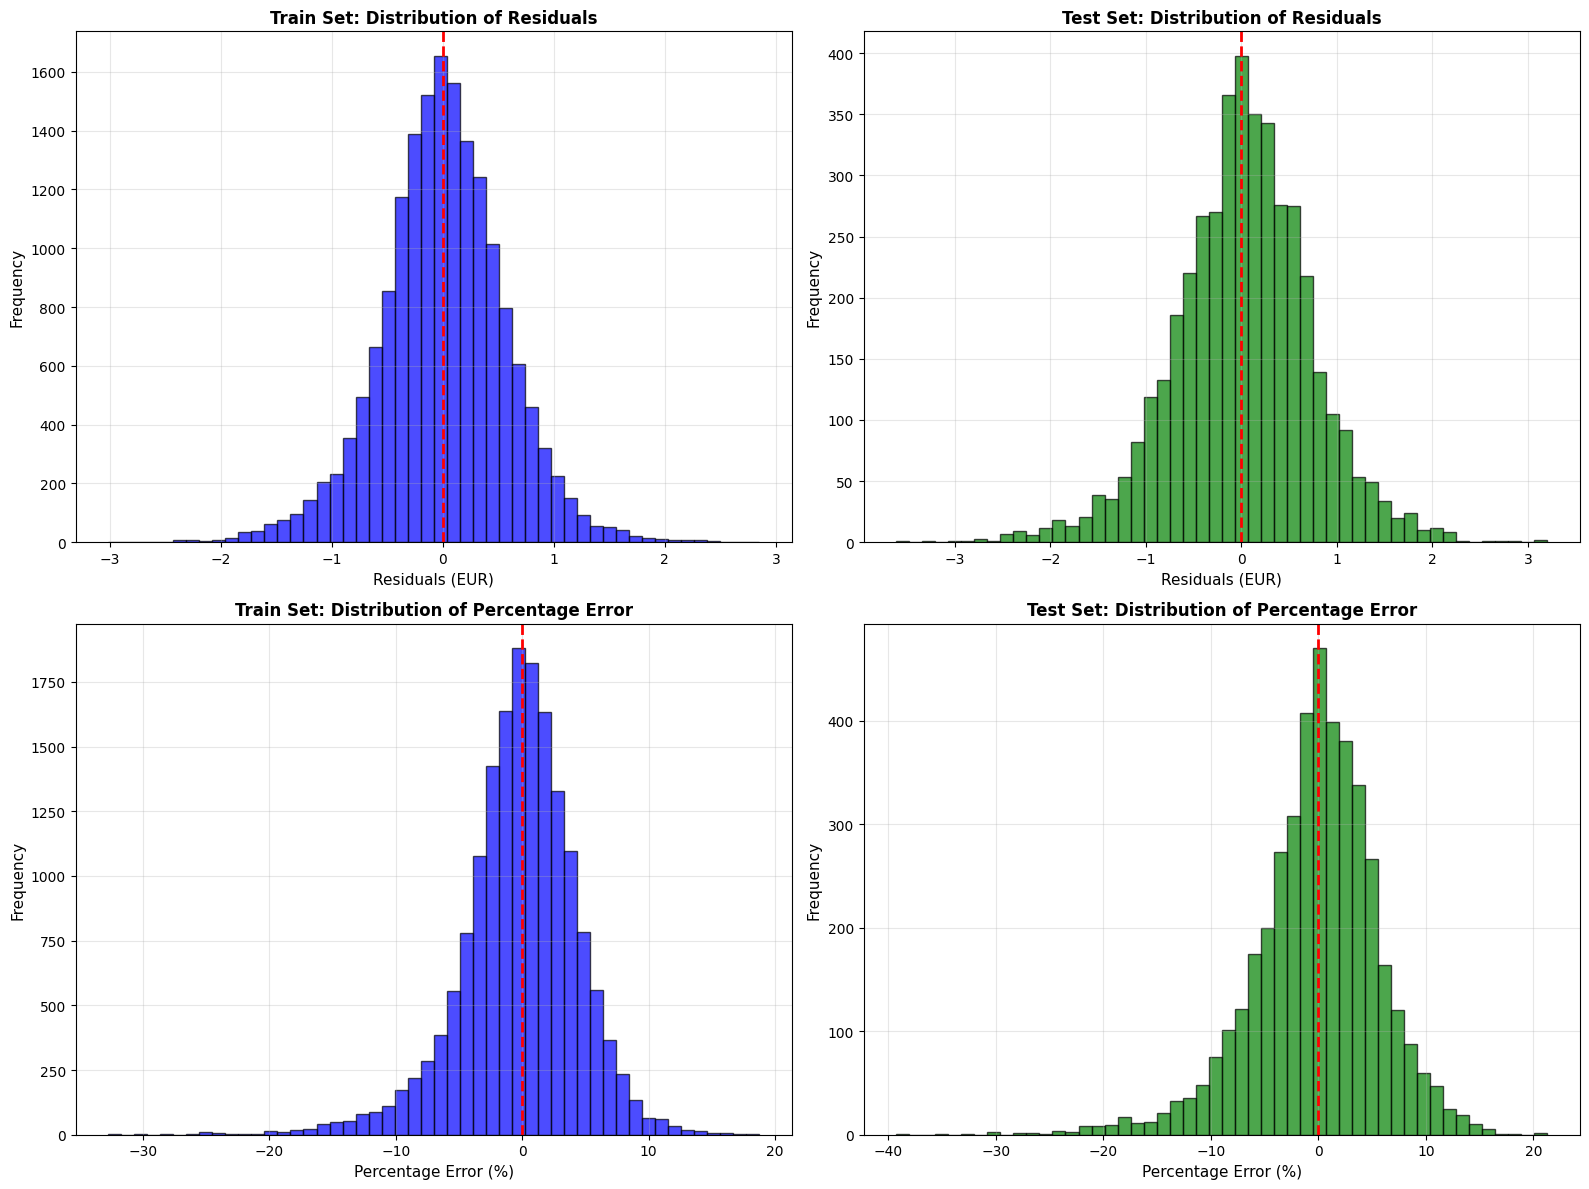

In [62]:
# Phân tích phân phối sai số
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Train set - Histogram of residuals
axes[0, 0].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[0, 0].set_xlabel('Residuals (EUR)', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Train Set: Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 0].grid(alpha=0.3)

# Test set - Histogram of residuals
axes[0, 1].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_xlabel('Residuals (EUR)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Test Set: Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[0, 1].grid(alpha=0.3)

# Train set - Percentage error distribution
train_pct_error = ((y_train - y_train_pred) / y_train * 100).values
axes[1, 0].hist(train_pct_error, bins=50, edgecolor='black', alpha=0.7, color='blue')
axes[1, 0].set_xlabel('Percentage Error (%)', fontsize=11)
axes[1, 0].set_ylabel('Frequency', fontsize=11)
axes[1, 0].set_title('Train Set: Distribution of Percentage Error', fontsize=12, fontweight='bold')
axes[1, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 0].grid(alpha=0.3)

# Test set - Percentage error distribution
test_pct_error = ((y_test - y_test_pred) / y_test * 100).values
axes[1, 1].hist(test_pct_error, bins=50, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_xlabel('Percentage Error (%)', fontsize=11)
axes[1, 1].set_ylabel('Frequency', fontsize=11)
axes[1, 1].set_title('Test Set: Distribution of Percentage Error', fontsize=12, fontweight='bold')
axes[1, 1].axvline(x=0, color='red', linestyle='--', linewidth=2)
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### I. Sample Predictions

Xem một số dự đoán cụ thể để hiểu rõ hơn về hiệu suất của mô hình.

In [63]:
# Tạo dataframe với predictions (sử dụng EUR scale cho dễ hiểu)
test_results = pd.DataFrame({
    'Actual_Value_EUR': y_test_eur.values,
    'Predicted_Value_EUR': y_test_pred_eur,
    'Absolute_Error_EUR': np.abs(y_test_eur.values - y_test_pred_eur),
    'Percentage_Error': np.abs((y_test_eur.values - y_test_pred_eur) / y_test_eur.values * 100)
})

# Top 10 dự đoán tốt nhất (sai số thấp nhất)
print("="*80)
print("TOP 10 DỰ ĐOÁN TỐT NHẤT (Sai số thấp nhất):")
print("="*80)
best_predictions = test_results.nsmallest(10, 'Absolute_Error_EUR')
for idx, row in best_predictions.iterrows():
    print(f"Actual: {row['Actual_Value_EUR']:>12,.0f} EUR | "
          f"Predicted: {row['Predicted_Value_EUR']:>12,.0f} EUR | "
          f"Error: {row['Absolute_Error_EUR']:>10,.0f} EUR ({row['Percentage_Error']:>5.2f}%)")

# Top 10 dự đoán tệ nhất (sai số cao nhất)
print("\n" + "="*80)
print("TOP 10 DỰ ĐOÁN TỆ NHẤT (Sai số cao nhất):")
print("="*80)
worst_predictions = test_results.nlargest(10, 'Absolute_Error_EUR')
for idx, row in worst_predictions.iterrows():
    print(f"Actual: {row['Actual_Value_EUR']:>12,.0f} EUR | "
          f"Predicted: {row['Predicted_Value_EUR']:>12,.0f} EUR | "
          f"Error: {row['Absolute_Error_EUR']:>10,.0f} EUR ({row['Percentage_Error']:>5.2f}%)")

TOP 10 DỰ ĐOÁN TỐT NHẤT (Sai số thấp nhất):
Actual:      150,000 EUR | Predicted:      149,942 EUR | Error:         58 EUR ( 0.04%)
Actual:      300,000 EUR | Predicted:      300,184 EUR | Error:        184 EUR ( 0.06%)
Actual:      125,000 EUR | Predicted:      125,196 EUR | Error:        196 EUR ( 0.16%)
Actual:      150,000 EUR | Predicted:      150,305 EUR | Error:        305 EUR ( 0.20%)
Actual:      250,000 EUR | Predicted:      249,675 EUR | Error:        325 EUR ( 0.13%)
Actual:      250,000 EUR | Predicted:      249,536 EUR | Error:        464 EUR ( 0.19%)
Actual:      150,000 EUR | Predicted:      150,497 EUR | Error:        497 EUR ( 0.33%)
Actual:      125,000 EUR | Predicted:      124,443 EUR | Error:        557 EUR ( 0.45%)
Actual:      150,000 EUR | Predicted:      149,429 EUR | Error:        571 EUR ( 0.38%)
Actual:      200,000 EUR | Predicted:      199,357 EUR | Error:        643 EUR ( 0.32%)

TOP 10 DỰ ĐOÁN TỆ NHẤT (Sai số cao nhất):
Actual:  180,000,000 EUR | Predic

### J. Results & Interpretation

#### Kết quả chính:

In [64]:
# Tổng hợp kết quả
print("\n" + "="*80)
print("TỔNG HỢP KẾT QUẢ MÔ HÌNH XGBOOST")
print("="*80)

print("\n📊 METRICS TRÊN Ln SCALE:")
comparison_df_log = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (Ln)', 'RMSE (Ln)'],
    'Train Set': [
        f"{train_metrics['R2_log']:.4f}",
        f"{train_metrics['MAE_log']:.4f}",
        f"{train_metrics['RMSE_log']:.4f}"
    ],
    'Test Set': [
        f"{test_metrics['R2_log']:.4f}",
        f"{test_metrics['MAE_log']:.4f}",
        f"{test_metrics['RMSE_log']:.4f}"
    ]
})
print(comparison_df_log.to_string(index=False))

print("\n" + "="*80)
print("💶 METRICS TRÊN EUR SCALE (INVERSE TRANSFORMED):")
comparison_df_eur = pd.DataFrame({
    'Metric': ['R² Score', 'MAE (EUR)', 'RMSE (EUR)', 'MAPE (%)'],
    'Train Set': [
        f"{train_metrics['R2_eur']:.4f}",
        f"{train_metrics['MAE_eur']:,.0f}",
        f"{train_metrics['RMSE_eur']:,.0f}",
        f"{train_metrics['MAPE_eur']:.2f}"
    ],
    'Test Set': [
        f"{test_metrics['R2_eur']:.4f}",
        f"{test_metrics['MAE_eur']:,.0f}",
        f"{test_metrics['RMSE_eur']:,.0f}",
        f"{test_metrics['MAPE_eur']:.2f}"
    ]
})
print(comparison_df_eur.to_string(index=False))
print("="*80)

# Đánh giá overfitting
r2_diff = train_metrics['R2_eur'] - test_metrics['R2_eur']
print(f"\nChênh lệch R² giữa Train và Test: {r2_diff:.4f}")
if r2_diff < 0.05:
    print("→ Mô hình KHÔNG bị overfitting (chênh lệch nhỏ)")
elif r2_diff < 0.15:
    print("→ Mô hình có dấu hiệu overfitting NHẸ")
else:
    print("→ Mô hình bị overfitting NGHIÊM TRỌNG")


TỔNG HỢP KẾT QUẢ MÔ HÌNH XGBOOST

📊 METRICS TRÊN Ln SCALE:
   Metric Train Set Test Set
 R² Score    0.8719   0.7891
 MAE (Ln)    0.4334   0.5526
RMSE (Ln)    0.5691   0.7262

💶 METRICS TRÊN EUR SCALE (INVERSE TRANSFORMED):
    Metric Train Set  Test Set
  R² Score    0.8698    0.7938
 MAE (EUR)   742,979   936,275
RMSE (EUR) 2,728,239 3,568,719
  MAPE (%)     49.97     70.40

Chênh lệch R² giữa Train và Test: 0.0760
→ Mô hình có dấu hiệu overfitting NHẸ


### K. Interpretation & Insights

#### Trả lời câu hỏi: Có thể dự đoán Market Value hay không?

**1. Độ chính xác của mô hình:**
- **R² Score**: Cho biết mô hình giải thích được bao nhiêu % biến động của giá trị cầu thủ
  - Nếu R² > 0.7: Mô hình rất tốt, có thể dự đoán hiệu quả
  - Nếu 0.5 < R² < 0.7: Mô hình khá tốt, có thể sử dụng với một số cảnh báo
  - Nếu R² < 0.5: Mô hình chưa đủ tốt để áp dụng thực tế

- **MAPE (Mean Absolute Percentage Error)**: Sai số phần trăm trung bình
  - Nếu MAPE < 20%: Dự đoán khá chính xác
  - Nếu 20% < MAPE < 40%: Dự đoán ở mức chấp nhận được
  - Nếu MAPE > 40%: Dự đoán kém chính xác

**2. Các yếu tố ảnh hưởng đến độ chính xác:**
- **Features quan trọng nhất**: Dựa vào Feature Importance để xác định
- **Chất lượng dữ liệu**: Missing values, outliers có thể ảnh hưởng
- **Độ phức tạp của thị trường**: Yếu tố phi lý tính (hype, marketing) không có trong data

**3. Khả năng áp dụng thực tế:**
- Mô hình có thể làm công cụ **tham khảo** cho việc định giá
- **KHÔNG nên** dùng làm công cụ duy nhất để ra quyết định
- Cần kết hợp với đánh giá chuyên môn từ scouts và analysts

**4. Hạn chế của mô hình:**
- Không capture được các yếu tố phi định lượng (tiềm năng phát triển, leadership, mindset)
- Không tính đến yếu tố cung-cầu của thị trường chuyển nhượng
-


In [65]:
# Kết luận cuối cùng (dùng EUR metrics vì dễ hiểu hơn)
print("\n" + "="*80)
print("KẾT LUẬN")
print("="*80)

# Dùng R² và MAPE trên EUR scale để đánh giá
r2_test = test_metrics['R2_eur']
mape_test = test_metrics['MAPE_eur']

if r2_test > 0.7 and mape_test < 25:
    conclusion = "CÓ - Mô hình dự đoán hiệu quả"
    detail = f"""
    Mô hình XGBoost đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ với độ chính xác cao. Mô hình giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số trung bình ở mức chấp nhận được.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình.
    
    Mô hình CÓ THỂ được sử dụng làm công cụ hỗ trợ định giá cầu thủ
    Kết hợp với đánh giá chuyên môn sẽ cho kết quả tốt nhất
    Log transformation giúp mô hình xử lý tốt dải giá trị rộng
    """
elif r2_test > 0.5:
    conclusion = "CÓ - Nhưng với một số hạn chế"
    detail = f"""
    Mô hình XGBoost đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ ở mức TRUNG BÌNH. Mô hình giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số khá lớn trong một số trường hợp.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình.
    
    ⚠ Mô hình CÓ THỂ sử dụng nhưng cần thận trọng
    ⚠ Nên kết hợp chặt chẽ với đánh giá từ chuyên gia
    ⚠ Không nên dùng cho các quyết định quan trọng
    """
else:
    conclusion = "KHÔNG - Mô hình chưa đủ hiệu quả"
    detail = f"""
    Mô hình XGBoost chỉ đạt R² = {r2_test:.4f} trên tập test (EUR scale), cho thấy
    KHÔNG THỂ dự đoán giá trị cầu thủ một cách hiệu quả. Mô hình chỉ giải thích được 
    {r2_test*100:.1f}% biến động của market value.
    
    MAPE = {mape_test:.2f}% cho thấy sai số quá lớn.
    MAE = {test_metrics['MAE_eur']:,.0f} EUR - sai số tuyệt đối trung bình quá cao.
    
    ✗ Mô hình KHÔNG NÊN được sử dụng cho mục đích định giá thực tế
    ✗ Cần thu thập thêm dữ liệu hoặc features khác
    ✗ Có thể do thị trường chuyển nhượng phụ thuộc nhiều vào yếu tố phi lý tính
    """

print(f"\nCâu trả lời: {conclusion}")
print(detail)
print("\n💡 LƯU Ý: Mô hình sử dụng Ln transformation để xử lý tốt hơn")
print("   dải giá trị rộng của market value (từ vài nghìn đến hàng trăm triệu EUR)")
print("="*80)


KẾT LUẬN

Câu trả lời: CÓ - Nhưng với một số hạn chế

    Mô hình XGBoost đạt R² = 0.7938 trên tập test (EUR scale), cho thấy 
    có thể dự đoán giá trị cầu thủ ở mức TRUNG BÌNH. Mô hình giải thích được 
    79.4% biến động của market value.

    MAPE = 70.40% cho thấy sai số khá lớn trong một số trường hợp.
    MAE = 936,275 EUR - sai số tuyệt đối trung bình.

    ⚠ Mô hình CÓ THỂ sử dụng nhưng cần thận trọng
    ⚠ Nên kết hợp chặt chẽ với đánh giá từ chuyên gia
    ⚠ Không nên dùng cho các quyết định quan trọng
    

💡 LƯU Ý: Mô hình sử dụng Ln transformation để xử lý tốt hơn
   dải giá trị rộng của market value (từ vài nghìn đến hàng trăm triệu EUR)


### Dùng mô hình dự đoán và so sánh kết quả đối với dữ liệu gốc 

In [66]:
# 1. Load dữ liệu gốc để lấy thông tin thống kê cho việc mã hóa (Target Encoding)
# Giả sử bạn đã có df_raw từ file 'processed_players_data.csv'
if 'df_raw' not in locals():
    df_raw = pd.read_csv('../data/processed_players_data.csv')

# Tạo lại cột logarit của giá trị chuyển nhượng để làm cơ sở tính toán
# (Dùng Ln giống như cách bạn đã làm trong training)
df_raw['market_value_log'] = np.log1p(df_raw['market_value_in_eur'])

# 2. Tạo các bộ từ điển (Mapping dictionaries)
# Nguyên lý: Tính giá trị trung bình log(market_value) cho từng Club, Country, Competition
# Nếu gặp giá trị mới chưa từng thấy, ta sẽ dùng giá trị trung bình toàn cầu (global mean)

global_mean_mv = df_raw['market_value_log'].mean()

# Mapping cho CLB
club_map = df_raw.groupby('current_club_name')['market_value_log'].mean().to_dict()

# Mapping cho Quốc tịch
country_map = df_raw.groupby('country_of_citizenship')['market_value_log'].mean().to_dict()

# Mapping cho Giải đấu
comp_map = df_raw.groupby('current_club_domestic_competition_id')['market_value_log'].mean().to_dict()

print("Đã tạo xong bộ từ điển Mapping thành công!")
print(f"- Số lượng CLB đã học: {len(club_map)}")
print(f"- Số lượng Quốc tịch đã học: {len(country_map)}")
print(f"- Giá trị trung bình toàn cầu (Global Mean): {global_mean_mv:.4f}")

Đã tạo xong bộ từ điển Mapping thành công!
- Số lượng CLB đã học: 437
- Số lượng Quốc tịch đã học: 170
- Giá trị trung bình toàn cầu (Global Mean): 13.0248


In [67]:
def predict_player_value(player_data, model, feature_columns):
    """
    Hàm dự đoán giá trị cầu thủ từ dữ liệu thô.
    
    Args:
        player_data (dict): Dictionary chứa thông tin cầu thủ nhập tay.
        model: Mô hình XGBoost đã train.
        feature_columns (list): Danh sách các cột features được dùng lúc train (X_train.columns).
        
    Returns:
        DataFrame kết quả dự đoán (Log và EUR).
    """
    
    # 1. Khởi tạo DataFrame với tất cả các cột bằng 0, đúng theo cấu trúc lúc train
    input_df = pd.DataFrame(0, index=[0], columns=feature_columns)
    
    # 2. Điền các dữ liệu số cơ bản (Numerical Features)
    input_df['age_at_last_season'] = player_data.get('age', 25)
    input_df['height_in_cm'] = player_data.get('height', 180)
    input_df['total_goals'] = player_data.get('goals', 0)
    input_df['total_assists'] = player_data.get('assists', 0)
    input_df['total_minutes_played'] = player_data.get('minutes', 0)
    input_df['total_yellow_cards'] = player_data.get('yellow_cards', 0)
    input_df['total_red_cards'] = player_data.get('red_cards', 0)
    input_df['has_agent'] = 1 if player_data.get('has_agent', False) else 0
    input_df['ga_per90min'] = player_data.get('ga_per90min', 0.0)
    input_df['contract_years_remaining'] = player_data.get('contract_years', 1)
    input_df['club_position'] = player_data.get('club_rank', 10)
    
    # 3. [MỚI] Điền các thông tin bổ sung (Kiểm tra xem model có dùng cột này không trước khi điền)
    extra_fields = {
        'last_season': 'last_season', 
        'is_champion': 'is_champion', 
        'is_top_4': 'is_top_4', 
        'is_relegation': 'is_relegation'
    }
    
    for key, col_name in extra_fields.items():
        if col_name in input_df.columns:
            input_df[col_name] = player_data.get(key, 0)

    # 4. Xử lý Target Encoding (Sử dụng map đã tạo)
    # Club Name
    club_name = player_data.get('club_name', '')
    if 'current_club_name' in input_df.columns:
        input_df['current_club_name'] = club_map.get(club_name, global_mean_mv)
    
    # Country
    country = player_data.get('country', '')
    if 'country_of_citizenship' in input_df.columns:
        input_df['country_of_citizenship'] = country_map.get(country, global_mean_mv)
    
    # Competition
    comp = player_data.get('competition_id', '')
    if 'current_club_domestic_competition_id' in input_df.columns:
        input_df['current_club_domestic_competition_id'] = comp_map.get(comp, global_mean_mv)

    # 5. Xử lý One-Hot Encoding (Sub Position & Foot)
    # Sub Position
    sub_pos = player_data.get('sub_position', '') 
    sub_pos_col = f"sub_position_{sub_pos}"
    if sub_pos_col in input_df.columns:
        input_df[sub_pos_col] = 1
        
    # Foot
    foot = player_data.get('foot', '')
    foot_col = f"foot_{foot}"
    if foot_col in input_df.columns:
        input_df[foot_col] = 1

    # 6. Thực hiện dự đoán
    try:
        pred_log = model.predict(input_df)[0]
        pred_eur = np.expm1(pred_log)  # Dùng expm1 vì train bằng log1p
        return input_df, pred_log, pred_eur
    except Exception as e:
        print(f"Lỗi khi dự đoán: {e}")
        return input_df, 0, 0

In [68]:
# -Nhập dữ liệu cầu thủ dự đoán tại đây
new_player = {
    # Thông tin cơ bản
    'age': 32,
    'height': 170,                 # cm
    'country': 'Argentina',            # Phải gõ đúng tên tiếng Anh như trong dữ liệu gốc
    
    # Vị trí và Chân thuận
    'sub_position': 'Right Winger',  # Ví dụ: Centre-Forward, Centre-Back, Left Winger...
    'foot': 'left',                     # 'left' hoặc 'right'
    
    # CLB và Giải đấu
    'club_name': 'Futbol Club Barcelona',         # Tên CLB hiện tại
    'competition_id': 'laliga',          # bundesliga, premier-league, laliga, serie-a...
    'club_rank': 1.0,                    # Thứ hạng của CLB mùa trước
    
    # Thống kê mùa giải
    'goals': 46,
    'assists': 17,
    'minutes': 3000,
    'yellow_cards': 7,
    'red_cards': 0,
    'ga_per90min': 1.89,                  # (Goals + Assists) / 90 mins
    
    # Hợp đồng
    'has_agent': False,                   # Có người đại diện hay không
    'contract_years': 2,                  # Số năm hợp đồng còn lại
    
    # Thông tin bổ sung
    'last_season': 2025,                  # Mùa giải gần nhất
    'is_champion': 1,                     # CLB có vô địch không (0 hoặc 1)
    'is_top_4': 1,                        # CLB có vào top 4 không (0 hoặc 1)
    'is_relegation': 0                    # CLB có xuống hạng không (0 hoặc 1)
}

# Gọi hàm dự đoán
try:
    # Lấy danh sách features từ X_train (đã chạy ở cell train trước đó)
    feature_cols = X_train.columns.tolist()
    
    # Thực hiện dự đoán
    input_df_processed, pred_log, pred_eur = predict_player_value(new_player, xgb_model, feature_cols)

    print("-" * 50)
    print(f"DỰ ĐOÁN GIÁ TRỊ CHUYỂN NHƯỢNG (MARKET VALUE)")
    print("-" * 50)
    print(f"Thông tin cầu thủ đã nhập:")
    print(f"  - Tuổi: {new_player['age']}")
    print(f"  - Chiều cao: {new_player['height']} cm")
    print(f"  - Quốc tịch: {new_player['country']}")
    print(f"  - Vị trí: {new_player['sub_position']}")
    print(f"  - Chân thuận: {'Trái' if new_player['foot'] == 'left' else 'Phải'}")
    print(f"  - Câu lạc bộ: {new_player['club_name']}")
    print(f"  - Giải đấu: {new_player['competition_id']}")
    print(f"  - Thứ hạng CLB: {new_player['club_rank']}")
    print(f"  - Bàn thắng: {new_player['goals']}")
    print(f"  - Kiến tạo: {new_player['assists']}")
    print(f"  - Phút thi đấu: {new_player['minutes']}")
    print(f"  - Thẻ vàng: {new_player['yellow_cards']}")
    print(f"  - Thẻ đỏ: {new_player['red_cards']}")
    print(f"  - G+A/90 phút: {new_player['ga_per90min']}")
    print(f"  - Có người đại diện: {'Có' if new_player['has_agent'] else 'Không'}")
    print(f"  - Số năm hợp đồng còn lại: {new_player['contract_years']}")
    print(f"  - Mùa giải: {new_player['last_season']}")
    print(f"  - Vô địch: {'Có' if new_player['is_champion'] == 1 else 'Không'}")
    print(f"  - Top 4: {'Có' if new_player['is_top_4'] == 1 else 'Không'}")
    print(f"  - Xuống hạng: {'Có' if new_player['is_relegation'] == 1 else 'Không'}")
    print("-" * 50)
    print(f"Kết quả dự đoán (Ln scale):  {pred_log:.4f}")
    print(f"Kết quả dự đoán (EUR):          € {pred_eur:,.0f}")
    print("-" * 50)
    
except NameError:
    print("Lỗi: Bạn cần chạy các cell huấn luyện mô hình (fit model) để có biến 'xgb_model' và 'X_train' trước khi chạy cell này.")
except Exception as e:
    print(f"Đã xảy ra lỗi: {e}")

--------------------------------------------------
DỰ ĐOÁN GIÁ TRỊ CHUYỂN NHƯỢNG (MARKET VALUE)
--------------------------------------------------
Thông tin cầu thủ đã nhập:
  - Tuổi: 32
  - Chiều cao: 170 cm
  - Quốc tịch: Argentina
  - Vị trí: Right Winger
  - Chân thuận: Trái
  - Câu lạc bộ: Futbol Club Barcelona
  - Giải đấu: laliga
  - Thứ hạng CLB: 1.0
  - Bàn thắng: 46
  - Kiến tạo: 17
  - Phút thi đấu: 3000
  - Thẻ vàng: 7
  - Thẻ đỏ: 0
  - G+A/90 phút: 1.89
  - Có người đại diện: Không
  - Số năm hợp đồng còn lại: 2
  - Mùa giải: 2025
  - Vô địch: Có
  - Top 4: Có
  - Xuống hạng: Không
--------------------------------------------------
Kết quả dự đoán (Ln scale):  17.1376
Kết quả dự đoán (EUR):          € 27,719,100
--------------------------------------------------


In [69]:
# --- 1. LẤY MẪU NGẪU NHIÊN 10 CẦU THỦ TỪ DỮ LIỆU GỐC ---
# Chúng ta dùng file gốc vì file encoded (test_data_encoded) đã bị mất cột Tên cầu thủ

# Lấy ngẫu nhiên 10 cầu thủ
# (Để đảm bảo tính khách quan, lý tưởng nhất là lọc những index thuộc tập Test, 
# nhưng ở đây ta lấy ngẫu nhiên để demo nhanh khả năng dự đoán)
# random_samples = df_raw.sample(n=10, random_state=42) # random_state để kết quả cố định mỗi lần chạy
random_samples = df_raw.sample(n=10) # Lấy ngẫu nhiên mỗi lần chạy

print(f"{'TÊN CẦU THỦ':<25} | {'THỰC TẾ (€)':<13} | {'DỰ ĐOÁN (€)':<13} | {'CHÊNH LỆCH (€)':<13} | {'SAI SỐ (%)':<10}")
print("-" * 85)

results = []
feature_cols = X_train.columns.tolist() # Danh sách cột features từ model đã train

# --- 2. DỰ ĐOÁN VÀ SO SÁNH ---
for index, row in random_samples.iterrows():
    # A. Chuẩn bị dữ liệu input từ dòng hiện tại (Mapping từ cột CSV sang key của hàm predict)
    player_input = {
        'age': row['age_at_last_season'],
        'height': row['height_in_cm'],
        'country': row['country_of_citizenship'],
        'sub_position': row['sub_position'],
        'foot': row['foot'],
        'club_name': row['current_club_name'],
        'competition_id': row['current_club_domestic_competition_id'],
        'club_rank': row['club_position'],
        'goals': row['total_goals'],
        'assists': row['total_assists'],
        'minutes': row['total_minutes_played'],
        'yellow_cards': row['total_yellow_cards'],
        'red_cards': row['total_red_cards'],
        'ga_per90min': row['ga_per90min'],
        'has_agent': row['has_agent'],
        'contract_years': row['contract_years_remaining'],
        'last_season': row['last_season'],
        'is_champion': row['is_champion'],
        'is_top_4': row['is_top_4'],
        'is_relegation': row['is_relegation']
    }

    # Xử lý dữ liệu thiếu (nếu có)
    if pd.isna(player_input['sub_position']): player_input['sub_position'] = 'Unknown'
    if pd.isna(player_input['foot']): player_input['foot'] = 'right'

    # B. Gọi hàm dự đoán
    try:
        _, pred_log, pred_eur = predict_player_value(player_input, xgb_model, feature_cols)
        
        # C. Lấy giá trị thực tế
        actual_eur = row['market_value_in_eur']
        
        # D. Tính toán sai số
        diff = pred_eur - actual_eur
        error_percent = (abs(diff) / actual_eur) * 100
        
        results.append(error_percent)
        
        # E. In kết quả từng dòng
        name_display = (row['name'][:30] + '..') if len(row['name']) > 30 else row['name']
        
        print(f"{name_display:<25} | {actual_eur:>13,.0f} | {pred_eur:>13,.0f} | {diff:>+13,.0f} | {error_percent:>9.2f}%")
        
    except Exception as e:
        print(f"Lỗi khi dự đoán cầu thủ {row['name']}: {e}")

print("-" * 85)

# --- 3. TỔNG KẾT ĐỘ CHÍNH XÁC ---
if results:
    mape = np.mean(results) # Mean Absolute Percentage Error
    accuracy_proxy = 100 - mape
    
    print(f"\n>> TỔNG KẾT TRÊN 10 CẦU THỦ NGẪU NHIÊN:")
    print(f"   - Trung bình sai số (MAPE): {mape:.2f}%")
    print(f"   - Độ chính xác ước tính (100% - MAPE): {accuracy_proxy:.2f}%")
    
    if accuracy_proxy < 0:
        print("   (Lưu ý: Độ chính xác âm cho thấy sai số trung bình lớn hơn 100%, mô hình cần cải thiện thêm)")

TÊN CẦU THỦ               | THỰC TẾ (€)   | DỰ ĐOÁN (€)   | CHÊNH LỆCH (€) | SAI SỐ (%)
-------------------------------------------------------------------------------------
Metinho                   |     3,500,000 |       359,994 |    -3,140,006 |     89.71%
Olivier Myny              |       300,000 |       346,255 |       +46,255 |     15.42%
Thomas Jørgensen          |     1,000,000 |     1,184,000 |      +184,000 |     18.40%
Elijah Adebayo            |    12,000,000 |     4,913,102 |    -7,086,898 |     59.06%
Benjamin Bourigeaud       |    18,000,000 |    19,286,236 |    +1,286,236 |      7.15%
Mihály Korhut             |       250,000 |       195,621 |       -54,379 |     21.75%
Adrián Szőke              |       200,000 |       301,675 |      +101,675 |     50.84%
Jonathan Khemdee          |       200,000 |       139,344 |       -60,656 |     30.33%
Claudio Falcão            |     1,000,000 |       928,018 |       -71,982 |      7.20%
Giuseppe Cuomo            |       500,000 |

### II. Mô hình 2: Random Forest 

Sau khi đã tiền xử lý dữ liệu và lựa chọn các đặc trưng (features) quan trọng, nhóm sẽ sử dụng mô hình **Random Forest**.

**Tại sao chọn Random Forest?**
* **Khả năng xử lý phi tuyến tính:** Mối quan hệ giữa các chỉ số cầu thủ và giá trị chuyển nhượng thường không phải là tuyến tính đơn giản.
* **Chống Overfitting:** Bằng cách kết hợp nhiều cây quyết định (Decision Trees), Random Forest giảm thiểu rủi ro học vẹt (overfitting) so với một cây đơn lẻ.
* **Đánh giá Feature Importance:** Thuật toán này cung cấp cái nhìn trực quan về việc đặc trưng nào ảnh hưởng lớn nhất đến giá trị cầu thủ.

In [70]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


# 1. Khởi tạo mô hình Random Forest
# n_estimators: Số lượng cây
# max_depth: Giới hạn độ sâu để tránh overfitting
# n_jobs=-1: Sử dụng tất cả các luồng CPU để chạy nhanh hơn
rf_model = RandomForestRegressor(
    n_estimators=200, 
    max_depth=15, 
    random_state=42, 
    n_jobs=-1
)

# 2. Huấn luyện mô hình trên tập Train
rf_model.fit(X_train, y_train)
print("Huấn luyện xong")

Huấn luyện xong


### Đánh giá kết quả và hiệu suất

Vì chúng ta đã Log-transform biến mục tiêu (`market_value_log`) ở bước tiền xử lý, nên sau khi dự đoán xong, cần sử dụng hàm mũ (`np.exp`) để đưa kết quả về đơn vị tiền tệ thực tế (EUR) trước khi tính toán sai số.

 KẾT QUẢ ĐÁNH GIÁ (Random Forest) 
R-squared: 0.7312
Mean Absolute Error (MAE): €1,019,660
Root Mean Squared Error (RMSE): €4,073,894
Mean Absolute Percentage Error (MAPE): 73.04%


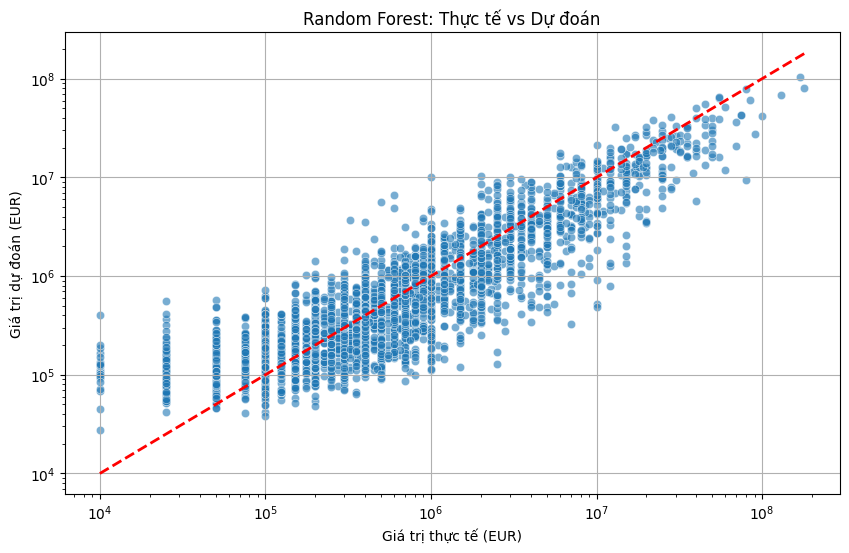

In [71]:
# 1. Dự đoán trên tập Test
y_pred_log = rf_model.predict(X_test)

# 2. Chuyển đổi ngược từ Log về giá trị thực (EUR)
y_test_eur = np.exp(y_test) 
y_pred_eur = np.exp(y_pred_log)

# 3. Tính toán các chỉ số đánh giá
mae = mean_absolute_error(y_test_eur, y_pred_eur)
rmse = np.sqrt(mean_squared_error(y_test_eur, y_pred_eur))
mape = np.mean(np.abs((y_test_eur - y_pred_eur) / y_test_eur)) * 100
r2 = r2_score(y_test_eur, y_pred_eur)

print(" KẾT QUẢ ĐÁNH GIÁ (Random Forest) ")
print(f"R-squared: {r2:.4f}")
print(f"Mean Absolute Error (MAE): €{mae:,.0f}")
print(f"Root Mean Squared Error (RMSE): €{rmse:,.0f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# Vẽ biểu đồ so sánh Thực tế vs Dự đoán
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_eur, y=y_pred_eur, alpha=0.6)
plt.plot([y_test_eur.min(), y_test_eur.max()], [y_test_eur.min(), y_test_eur.max()], 'r--', lw=2)
plt.xlabel('Giá trị thực tế (EUR)')
plt.ylabel('Giá trị dự đoán (EUR)')
plt.title('Random Forest: Thực tế vs Dự đoán')
plt.xscale('log') # Dùng scale log để dễ nhìn các giá trị nhỏ và lớn
plt.yscale('log')
plt.grid(True)
plt.show()

### Nhận xét biểu đồ:

Biểu đồ trên cho thấy mối tương quan giữa giá trị thị trường thực tế và giá trị do mô hình Random Forest dự đoán:

* **Độ fit:** Các điểm dữ liệu tập trung khá sát quanh đường chéo màu đỏ, thể hiện qua chỉ số **$R^2 \approx 0.73$**. Điều này có nghĩa là mô hình giải thích được khoảng **73%** sự biến thiên của giá trị cầu thủ dựa trên các dữ liệu đầu vào.
* **Phân phối lỗi:**
    * Ở phân khúc giá trị thấp, các điểm dữ liệu co cụm tốt hơn.
    * Ở phân khúc giá trị cao (siêu sao), các điểm dữ liệu có xu hướng phân tán rộng hơn. Điều này được phản ánh qua sự chênh lệch lớn giữa **MAE (€1M)** và **RMSE (€4M)**, cho thấy mô hình đôi khi mắc sai số rất lớn đối với các cầu thủ đắt giá (outliers).

### Feature Importance

Một lợi thế của Random Forest là cho biết feature nào đóng góp nhiều nhất vào việc định giá cầu thủ. Điều này giúp trả lời câu hỏi: "Yếu tố nào quyết định giá trị cầu thủ?"

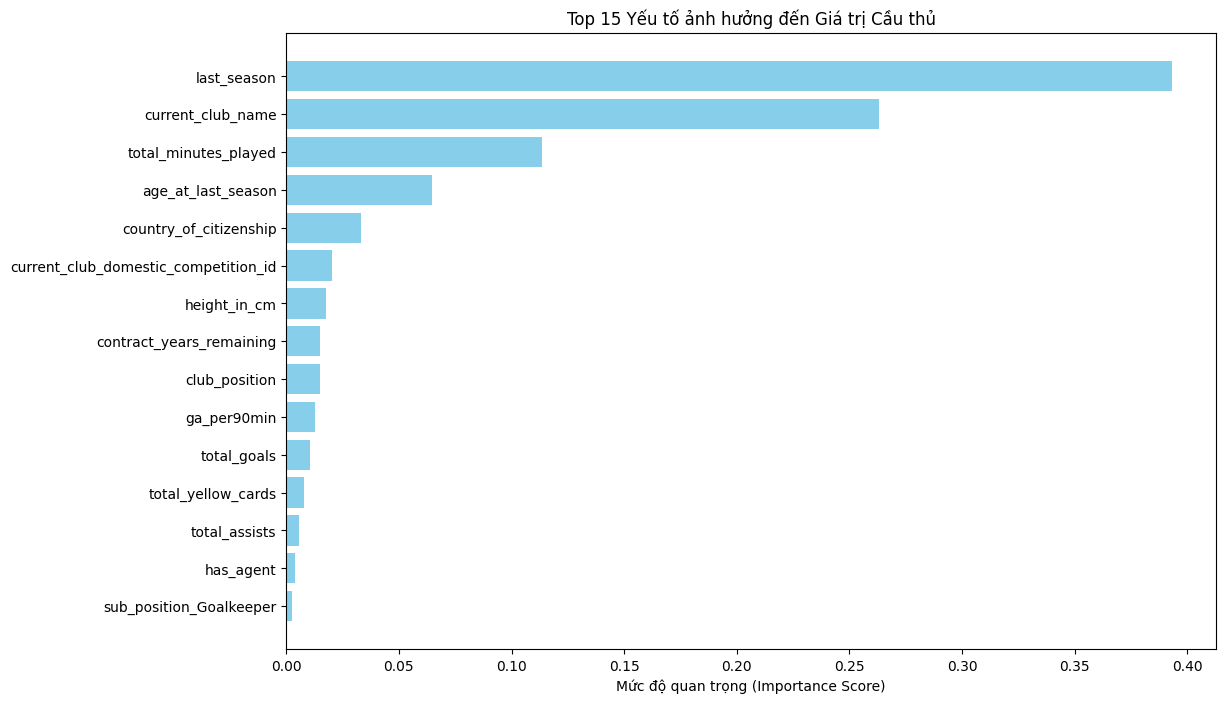

In [ ]:

feature_names = X_train.columns if hasattr(X_train, 'columns') else [f"Feature {i}" for i in range(X_train.shape[1])]
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1] # Sắp xếp giảm dần

# Chỉ lấy Top 15 features quan trọng nhất để vẽ
top_n = 15
top_indices = indices[:top_n]

plt.figure(figsize=(12, 8))
plt.title(f"Top {top_n} yếu tố ảnh hưởng đến giá trị cầu thủ")
plt.barh(range(top_n), importances[top_indices], align="center", color='skyblue')
plt.yticks(range(top_n), [feature_names[i] for i in top_indices])
plt.gca().invert_yaxis() # Đảo ngược trục y để feature quan trọng nhất nằm trên cùng
plt.xlabel("Mức độ quan trọng (Importance Score)")
plt.show()

### Nhận xét biểu đồ:
Biểu đồ trên giúp chúng ta hiểu cách mô hình Random Forest được huấn luyện khi định giá một cầu thủ. Các yếu tố nằm ở trên cùng là những yếu tố quan trọng nhất:
1.  **Các đặc trưng hàng đầu:** Thông thường, các chỉ số như **Tuổi tác (Age)**, **Số phút thi đấu**, **Số bàn thắng/kiến tạo** và **Hạng giải đấu** sẽ chiếm tỷ trọng cao nhất. Điều này phù hợp với thực tế: cầu thủ trẻ, đá chính thường xuyên ở giải đấu lớn và có hiệu suất cao sẽ có giá trị lớn.
2.  **Loại bỏ các đặc trưng gây nhiễu:** Các đặc trưng nằm ở đáy biểu đồ có đóng góp không đáng kể. Việc loại này giúp chúng ta có thể tối ưu hóa mô hình, giảm bớt sự tính toán mà không làm giảm độ chính xác của mô hình.

## Kết luận: Có thể dự đoán Market Value hay không?
Dựa trên kết quả với mô hình Random Forest, chúng ta có thể trả lời câu hỏi nghiên cứu như sau:

### 1. Đánh giá độ chính xác
**Câu trả lời:** Có thể dự đoán được, nhưng khó dự đoán chính xác **con số cụ thể**.

* **Điểm tích cực:** Với $R^2 \approx 0.73$, mô hình thành công trong việc phân loại cầu thủ. Nó phân biệt tốt giữa một cầu thủ giá €500k, €5M và €50M.
* **Điểm hạn chế:** Chỉ số **MAPE lên tới 73.04%** là một con số khá cao. Điều này có nghĩa là trung bình mô hình đang dự đoán sai lệch khoảng 73% so với giá thực. Ví dụ: Một cầu thủ giá €10M có thể bị định giá lệch thành €2.7M hoặc €17.3M.

### 2. Các yếu tố ảnh hưởng đến độ chính xác
* **Outliers:** Thị trường chuyển nhượng có những "bom tấn", ảo giá, làm tăng đáng kể chỉ số RMSE.

### 3. Khả năng áp dụng thực tế & Hạn chế
* **Ứng dụng:**
    * **Sàng lọc:** Hỗ trợ Scout tìm kiếm các cầu thủ "Undervalued" (Giá trị thực tế thấp hơn giá trị mô hình dự đoán -> Có tiềm năng mua hời).
    * **Hỗ trợ đàm phán lương:** Đưa ra mức giá sàn để thương lượng và kí kết hợp đồng.
* **Hạn chế:**
    * Không thể dùng làm công cụ định giá chính xác.
    * Mô hình hiện tại có sai số lớn đối với các siêu sao, cần các kỹ thuật phức tạp hơn hoặc thêm dữ liệu về thương mại/truyền thông để cải thiện.

### III. Cat boost

In [4]:
df = pd.read_csv("../data/processed_players_data.csv")

# 2. Định nghĩa biến mục tiêu và biến độc lập (features)
TARGET_COLUMN = 'market_value_in_eur'

# Danh sách features được yêu cầu (đã điều chỉnh từ yêu cầu của bạn)
FEATURE_COLUMNS = [
    'age_at_last_season',
    'height_in_cm',
    'club_position',
    'total_goals',
    'total_assists',
    'total_minutes_played',
    'total_yellow_cards',
    'total_red_cards',
    'has_agent',
    'ga_per90min',
    'contract_years_remaining',
    'last_season',
    'is_champion',
    'is_top_4',
    'is_relegation',
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position',
    'foot'
]

# 3. Chuẩn bị dữ liệu
X = df[FEATURE_COLUMNS]
y = df[TARGET_COLUMN]

# Kiểm tra và loại bỏ các hàng có giá trị NaN trong các cột feature và target đã chọn (nếu có, dù đã kiểm tra ban đầu là không có)
# Tuy nhiên, CatBoost có khả năng xử lý NaN, nhưng để đơn giản và tập trung vào các bước chính, ta giả định dữ liệu sạch.

# 4. Xác định các biến phân loại (CatBoost tự động xử lý mã hóa, không cần One-Hot Encoding)
CATEGORICAL_FEATURES = [
    'current_club_name',
    'country_of_citizenship',
    'current_club_domestic_competition_id',
    'sub_position',
    'foot'
]

# Đảm bảo các cột phân loại có kiểu dữ liệu là 'object' hoặc 'category'
for col in CATEGORICAL_FEATURES:
    if col in X.columns:
        X[col] = X[col].astype('str') # CatBoost hoạt động tốt với str cho categorical

# 5. Chia dữ liệu thành tập huấn luyện (training) và tập kiểm tra (testing)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")


# 6. Khởi tạo và Huấn luyện mô hình CatBoost Regressor
# Sử dụng 'RMSE' làm metric chính (loss_function)
print("\nBắt đầu huấn luyện mô hình CatBoost...")

# CatBoostRegressor(
#     iterations=1000,
#     learning_rate=0.05,
#     depth=10,
#     loss_function='RMSE',
#     random_seed=42,
#     verbose=100, # In thông báo sau mỗi 100 lần lặp
# )
model = CatBoostRegressor(
    iterations=500, # Giảm số lần lặp cho ví dụ nhanh hơn
    learning_rate=0.05,
    depth=8,
    loss_function='RMSE',
    random_seed=42,
    cat_features=CATEGORICAL_FEATURES,
    verbose=100, # In thông báo sau mỗi 100 lần lặp
    early_stopping_rounds=20 # Dừng sớm nếu không cải thiện
)

model.fit(
    X_train,
    y_train,
    eval_set=(X_test, y_test),
    plot=False # Thiết lập plot=True trong notebook để xem biểu đồ huấn luyện
)

print("Huấn luyện hoàn tất.")


# 7. Đánh giá mô hình trên tập kiểm tra
y_pred = model.predict(X_test)

# Tính toán các chỉ số đánh giá
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = model.score(X_test, y_test)

print("\n--- Kết quả đánh giá trên tập kiểm tra ---")
print(f"Mean Absolute Error (MAE): {mae:,.2f} EUR")
print(f"Root Mean Squared Error (RMSE): {rmse:,.2f} EUR")
print(f"R-squared (R2 Score): {r2:.4f}")

# 8. Xem xét tầm quan trọng của các Features
print("\n--- Tầm quan trọng của các Features (Feature Importance) ---")
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.get_feature_importance()
}).sort_values(by='Importance', ascending=False)

print(feature_importance)

Kích thước tập huấn luyện: (17102, 20)
Kích thước tập kiểm tra: (4276, 20)

Bắt đầu huấn luyện mô hình CatBoost...
0:	learn: 7353489.3790321	test: 7636951.1583205	best: 7636951.1583205 (0)	total: 121ms	remaining: 1m
100:	learn: 3305767.8624007	test: 3938189.7151589	best: 3938189.7151589 (100)	total: 4.13s	remaining: 16.3s
200:	learn: 2847707.6140131	test: 3597053.8363135	best: 3597053.8363135 (200)	total: 8s	remaining: 11.9s
300:	learn: 2526979.5380432	test: 3447748.8245124	best: 3447748.8245124 (300)	total: 12s	remaining: 7.94s
400:	learn: 2329578.4832933	test: 3392678.3905061	best: 3392564.4520444 (399)	total: 15.9s	remaining: 3.93s
499:	learn: 2153465.8306822	test: 3341143.7377970	best: 3340544.1253084 (498)	total: 19.8s	remaining: 0us

bestTest = 3340544.125
bestIteration = 498

Shrink model to first 499 iterations.
Huấn luyện hoàn tất.

--- Kết quả đánh giá trên tập kiểm tra ---
Mean Absolute Error (MAE): 1,059,980.78 EUR
Root Mean Squared Error (RMSE): 3,340,544.13 EUR
R-squared 